In [1]:
#!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 20.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns
import h5py # pour gérer les formats de données utilisés ici
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# TP3: Reconnaissance de signaux de communication par apprentissage profond

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

2 séances de TP sur ce sujet : le 6 novembre (1h00), le 13 novembre (3h).
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br>
Deadline pour le rendu du TP: 26 novembre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

**Liste des noms :**
- Abdellah REBAINE
- Enzo BENBALIT

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétique comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [ ]:
_REP_PATH_ = '/content/'


In [170]:
data_path = _REP_PATH_ + 'samples.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

signals.shape

(200, 2048, 2)

In [169]:
snr.shape

(30000,)

In [ ]:
labels_id.shape

(200,)

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [ ]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

In [ ]:
with h5py.File(data_path, 'r') as data:
    labels_dic = get_labels(data)

for label in labels_dic:
    print(f"La classe {label} correspond au standard d'émetteur {labels_dic[label]}")

La classe 1 correspond au standard d'émetteur N-PSK8
La classe 0 correspond au standard d'émetteur N-QAM16
La classe 2 correspond au standard d'émetteur N-QPSK
La classe 4 correspond au standard d'émetteur W-PSK8-V1
La classe 5 correspond au standard d'émetteur W-PSK8-V2
La classe 3 correspond au standard d'émetteur W-QAM16


### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering

In [8]:
data_path = _REP_PATH_ + 'train.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

signals.shape

(30000, 2048, 2)

**Distribution des SNR**

[]

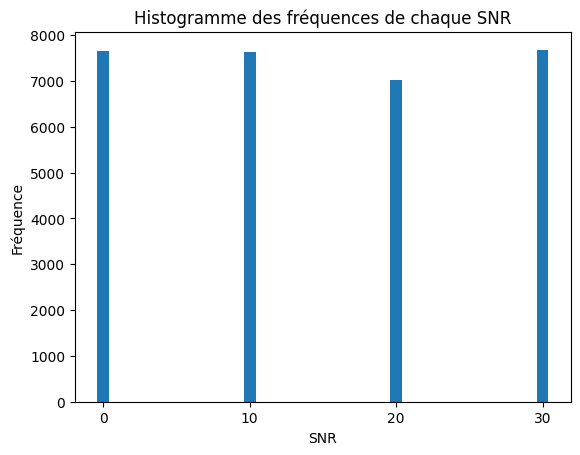

In [9]:
unique, count = np.unique(snr, return_counts=True)

plt.bar(unique, count)
plt.xlabel("SNR")
plt.ylabel("Fréquence")
plt.title('Histogramme des fréquences de chaque SNR')
plt.xticks(unique)
plt.plot()

In [10]:
for el in np.unique(snr):
    print(f"Il y a {len(snr[snr== el])} signaux dont le SNR est {el}")

Il y a 7660 signaux dont le SNR est 0
Il y a 7640 signaux dont le SNR est 10
Il y a 7020 signaux dont le SNR est 20
Il y a 7680 signaux dont le SNR est 30


La distribution des SNR est très équilibrées, chaque valeur de SNR est associée à environ 1/4 des données.

**Distribution des classes**

[]

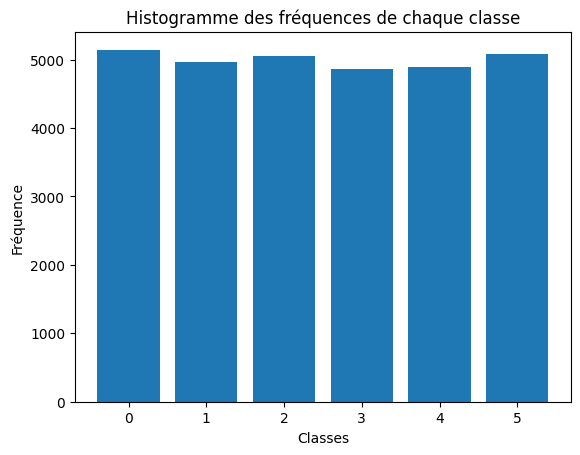

In [11]:
unique, count = np.unique(labels_id, return_counts=True)

plt.bar(unique, count)
plt.xlabel("Classes")
plt.ylabel("Fréquence")
plt.title('Histogramme des fréquences de chaque classe')
plt.xticks(unique)
plt.plot()

In [12]:
for el in np.unique(labels_id):
    print(f"Il y a {len(labels_id[labels_id== el])} signaux dont la classe est {el}")

Il y a 5143 signaux dont la classe est 0
Il y a 4968 signaux dont la classe est 1
Il y a 5053 signaux dont la classe est 2
Il y a 4867 signaux dont la classe est 3
Il y a 4894 signaux dont la classe est 4
Il y a 5075 signaux dont la classe est 5


Les classes sont également distribuées de manière uniforme.

### Visualisation des données

On se propose de visualer les données dans les domaines temporels et fréquentiels pour chaque classe, pour les deux niveaux de SNR les plus extrêmes (0 dB et 30 dB).

In [13]:
# Pour chaque SNR, pour chaque classe, on cherche des exemples

sample_from_each_classes_SNR0 = []
already_seen = set()
for i in range(len(labels_id)):
    if labels_id[i] not in already_seen and snr[i] == 0:
        already_seen.add(labels_id[i])
        sample_from_each_classes_SNR0.append((i,int(labels_id[i])))
    if len(already_seen) == 6:
        break
sample_from_each_classes_SNR0 = sorted(sample_from_each_classes_SNR0, key=lambda x:x[1])

sample_from_each_classes_SNR10 = []
already_seen = set()
for i in range(len(labels_id)):
    if labels_id[i] not in already_seen and snr[i] == 10:
        already_seen.add(labels_id[i])
        sample_from_each_classes_SNR10.append((i,int(labels_id[i])))
    if len(already_seen) == 6:
        break
sample_from_each_classes_SNR10 = sorted(sample_from_each_classes_SNR10, key=lambda x:x[1])

sample_from_each_classes_SNR20 = []
already_seen = set()
for i in range(len(labels_id)):
    if labels_id[i] not in already_seen and snr[i] == 20:
        already_seen.add(labels_id[i])
        sample_from_each_classes_SNR20.append((i,int(labels_id[i])))
    if len(already_seen) == 6:
        break
sample_from_each_classes_SNR20 = sorted(sample_from_each_classes_SNR20, key=lambda x:x[1])

sample_from_each_classes_SNR30 = []
already_seen = set()
for i in range(len(labels_id)):
    if labels_id[i] not in already_seen and snr[i] == 30:
        already_seen.add(labels_id[i])
        sample_from_each_classes_SNR30.append((i,int(labels_id[i])))
    if len(already_seen) == 6:
        break
sample_from_each_classes_SNR30 = sorted(sample_from_each_classes_SNR30, key=lambda x:x[1])

**Dans le domaine temporel**

In [14]:
def plot_samples_from_each_class(signals, labels_id, snr, sample_indices):
    fig, axes = plt.subplots(6, 1, figsize=(15, 30))
    axes = axes.ravel()

    for idx, (sample_idx, label) in enumerate(sample_indices):
        signal = signals[sample_idx]

        # Tracé de la partie réelle et imaginaire du signal
        axes[idx].plot(signal[:, 0], label="In-phase", color='blue')
        axes[idx].plot(signal[:, 1], label="Quadrature", color='orange', linestyle='--')

        # Configuration des sous-graphiques
        axes[idx].set_title(f"Classe {label} - SNR: {snr[sample_idx]} dB")
        axes[idx].set_xlabel("Échantillon")
        axes[idx].set_ylabel("Amplitude")
        axes[idx].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

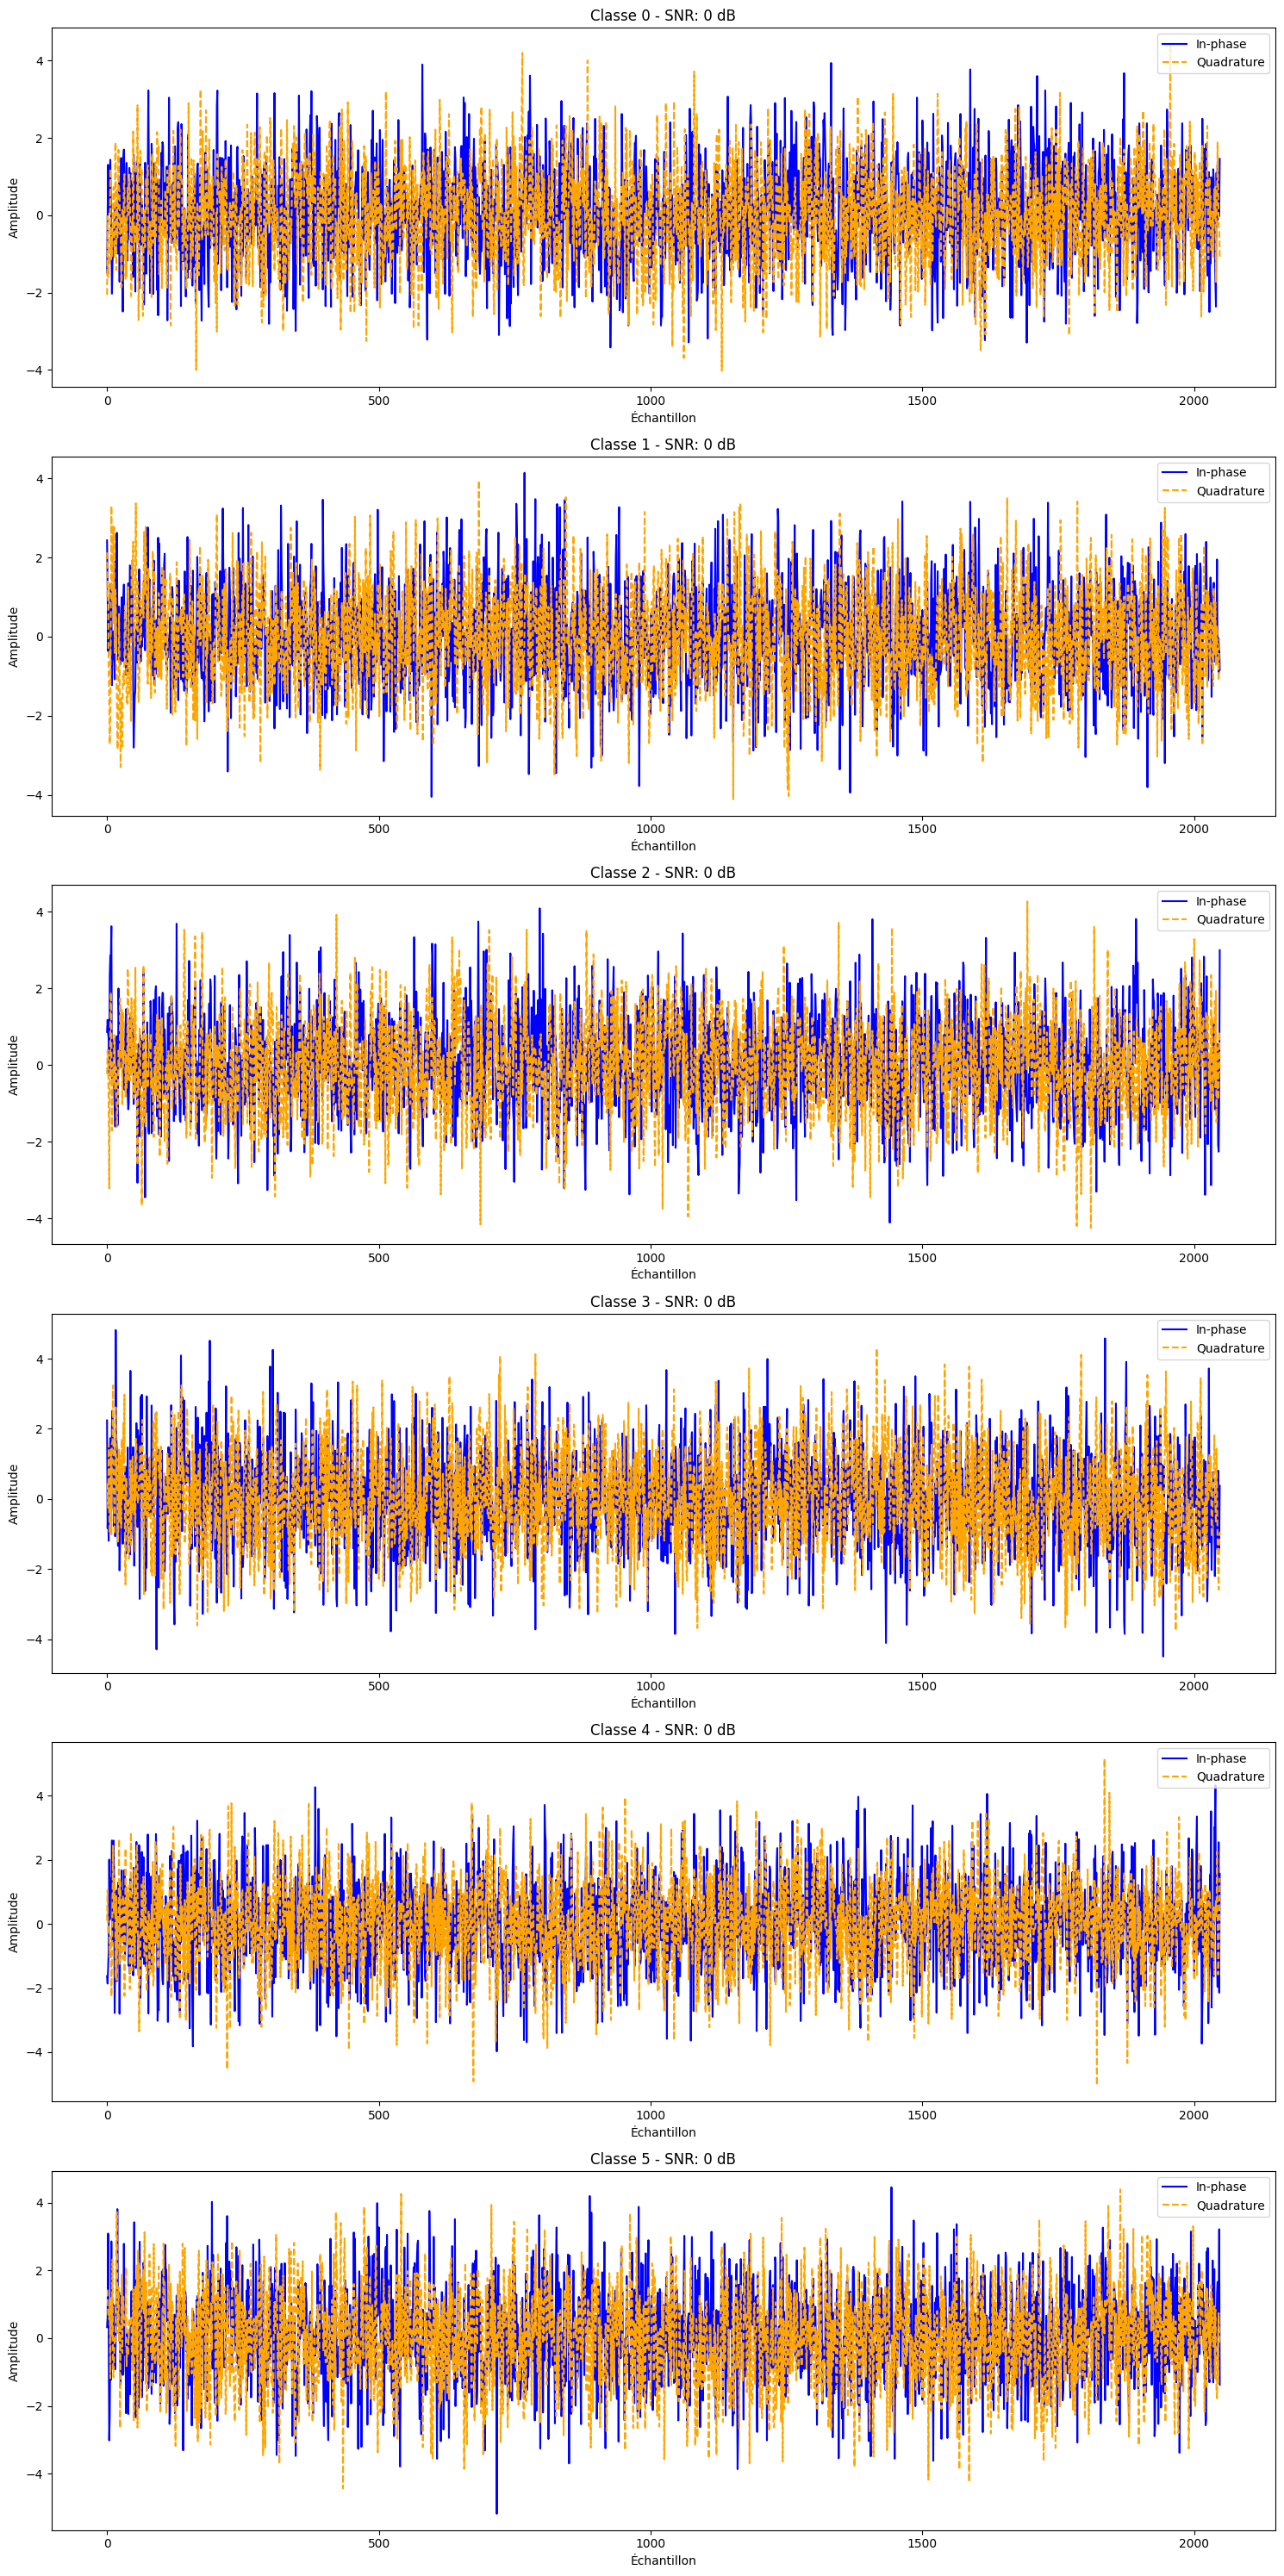

In [ ]:
# Pour un SNR de 0 dB
plot_samples_from_each_class(signals, labels_id, snr, sample_from_each_classes_SNR0)

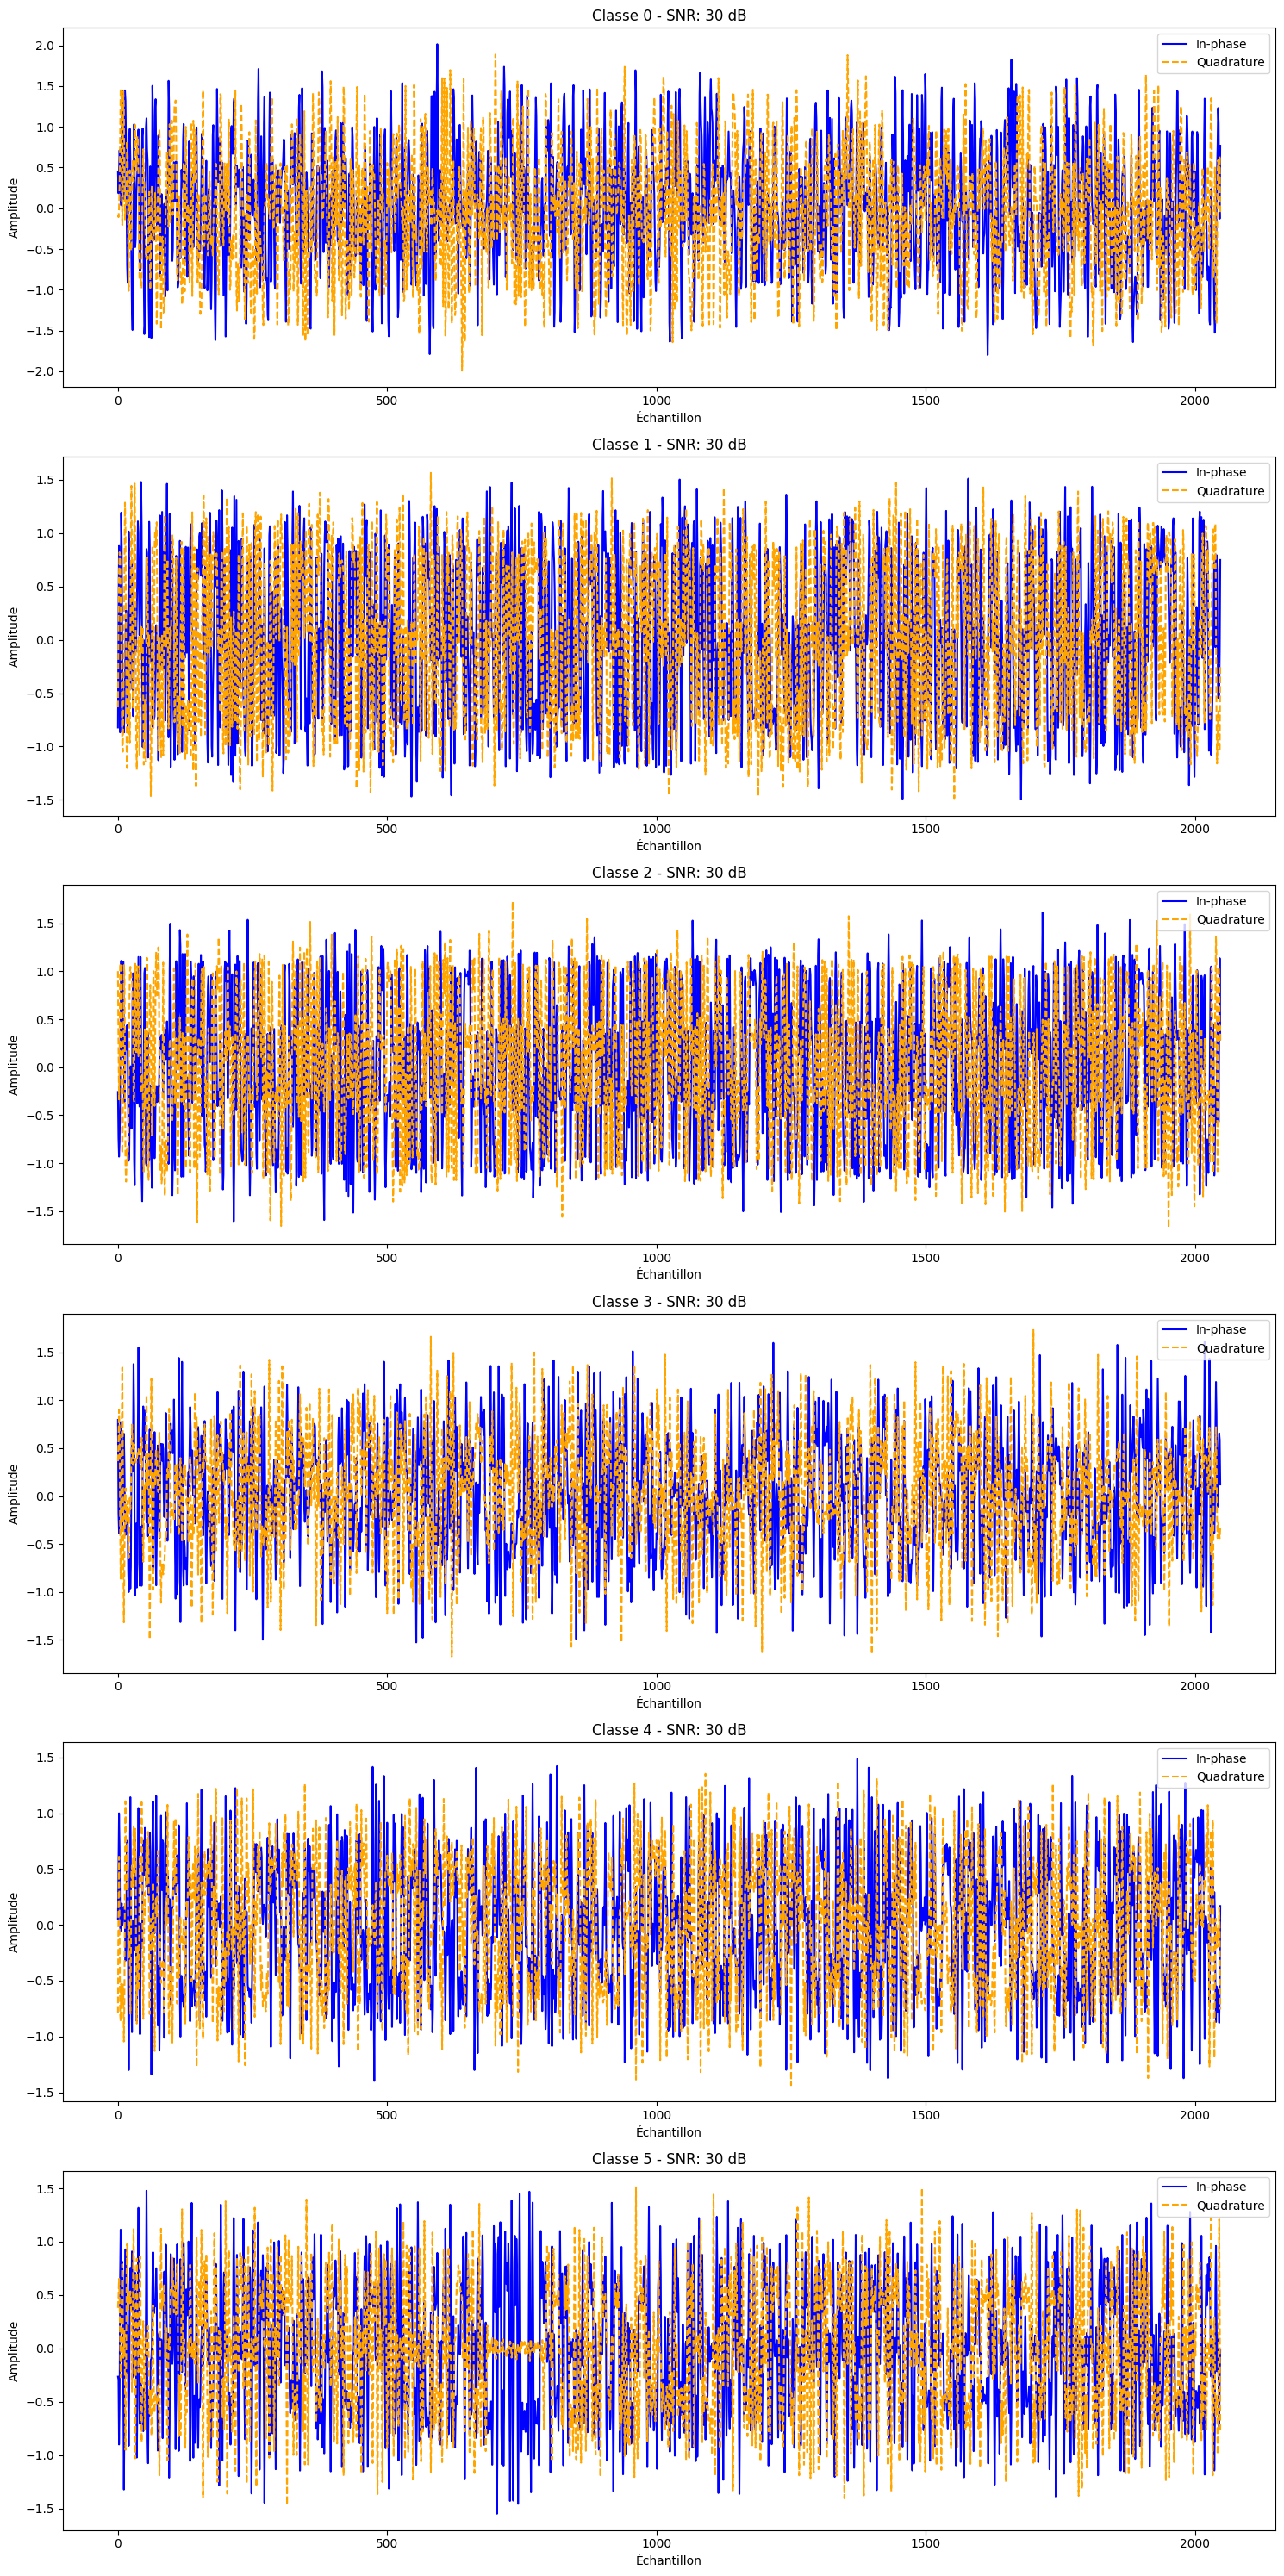

In [ ]:
# Pour un SNR de 30 dB
plot_samples_from_each_class(signals, labels_id, snr, sample_from_each_classes_SNR30)

On observe très peu de différences entre les signaux dans le domaine temporel, il y a parfois quelques différences, mais il est difficile de dire si cela est caractéristique de la classe ou plutôt si cela est juste lié au caractère unique de l'échantillon.

**Dans le domaine fréquentiel**

In [16]:
def plot_samples_from_each_class_freq(signals, labels_id, snr, sample_indices):
    fig, axes = plt.subplots(6, 1, figsize=(15, 30))
    axes = axes.ravel()

    for idx, (sample_idx, label) in enumerate(sample_indices):
        signal = signals[sample_idx]
        spectrum = np.fft.fftshift(np.fft.fft(signal[:,0]+1j*signal[:,1]))
        freq = np.fft.fftshift(np.fft.fftfreq(len(signal[:,0])))


        # Tracé de la partie réelle et imaginaire du signal
        axes[idx].plot(freq, abs(spectrum), label="DFT", color='blue')

        # Configuration des sous-graphiques
        axes[idx].set_title(f"Classe {label} - SNR: {snr[sample_idx]} dB")
        axes[idx].set_xlabel("Échantillon")
        axes[idx].set_ylabel("Amplitude")
        axes[idx].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

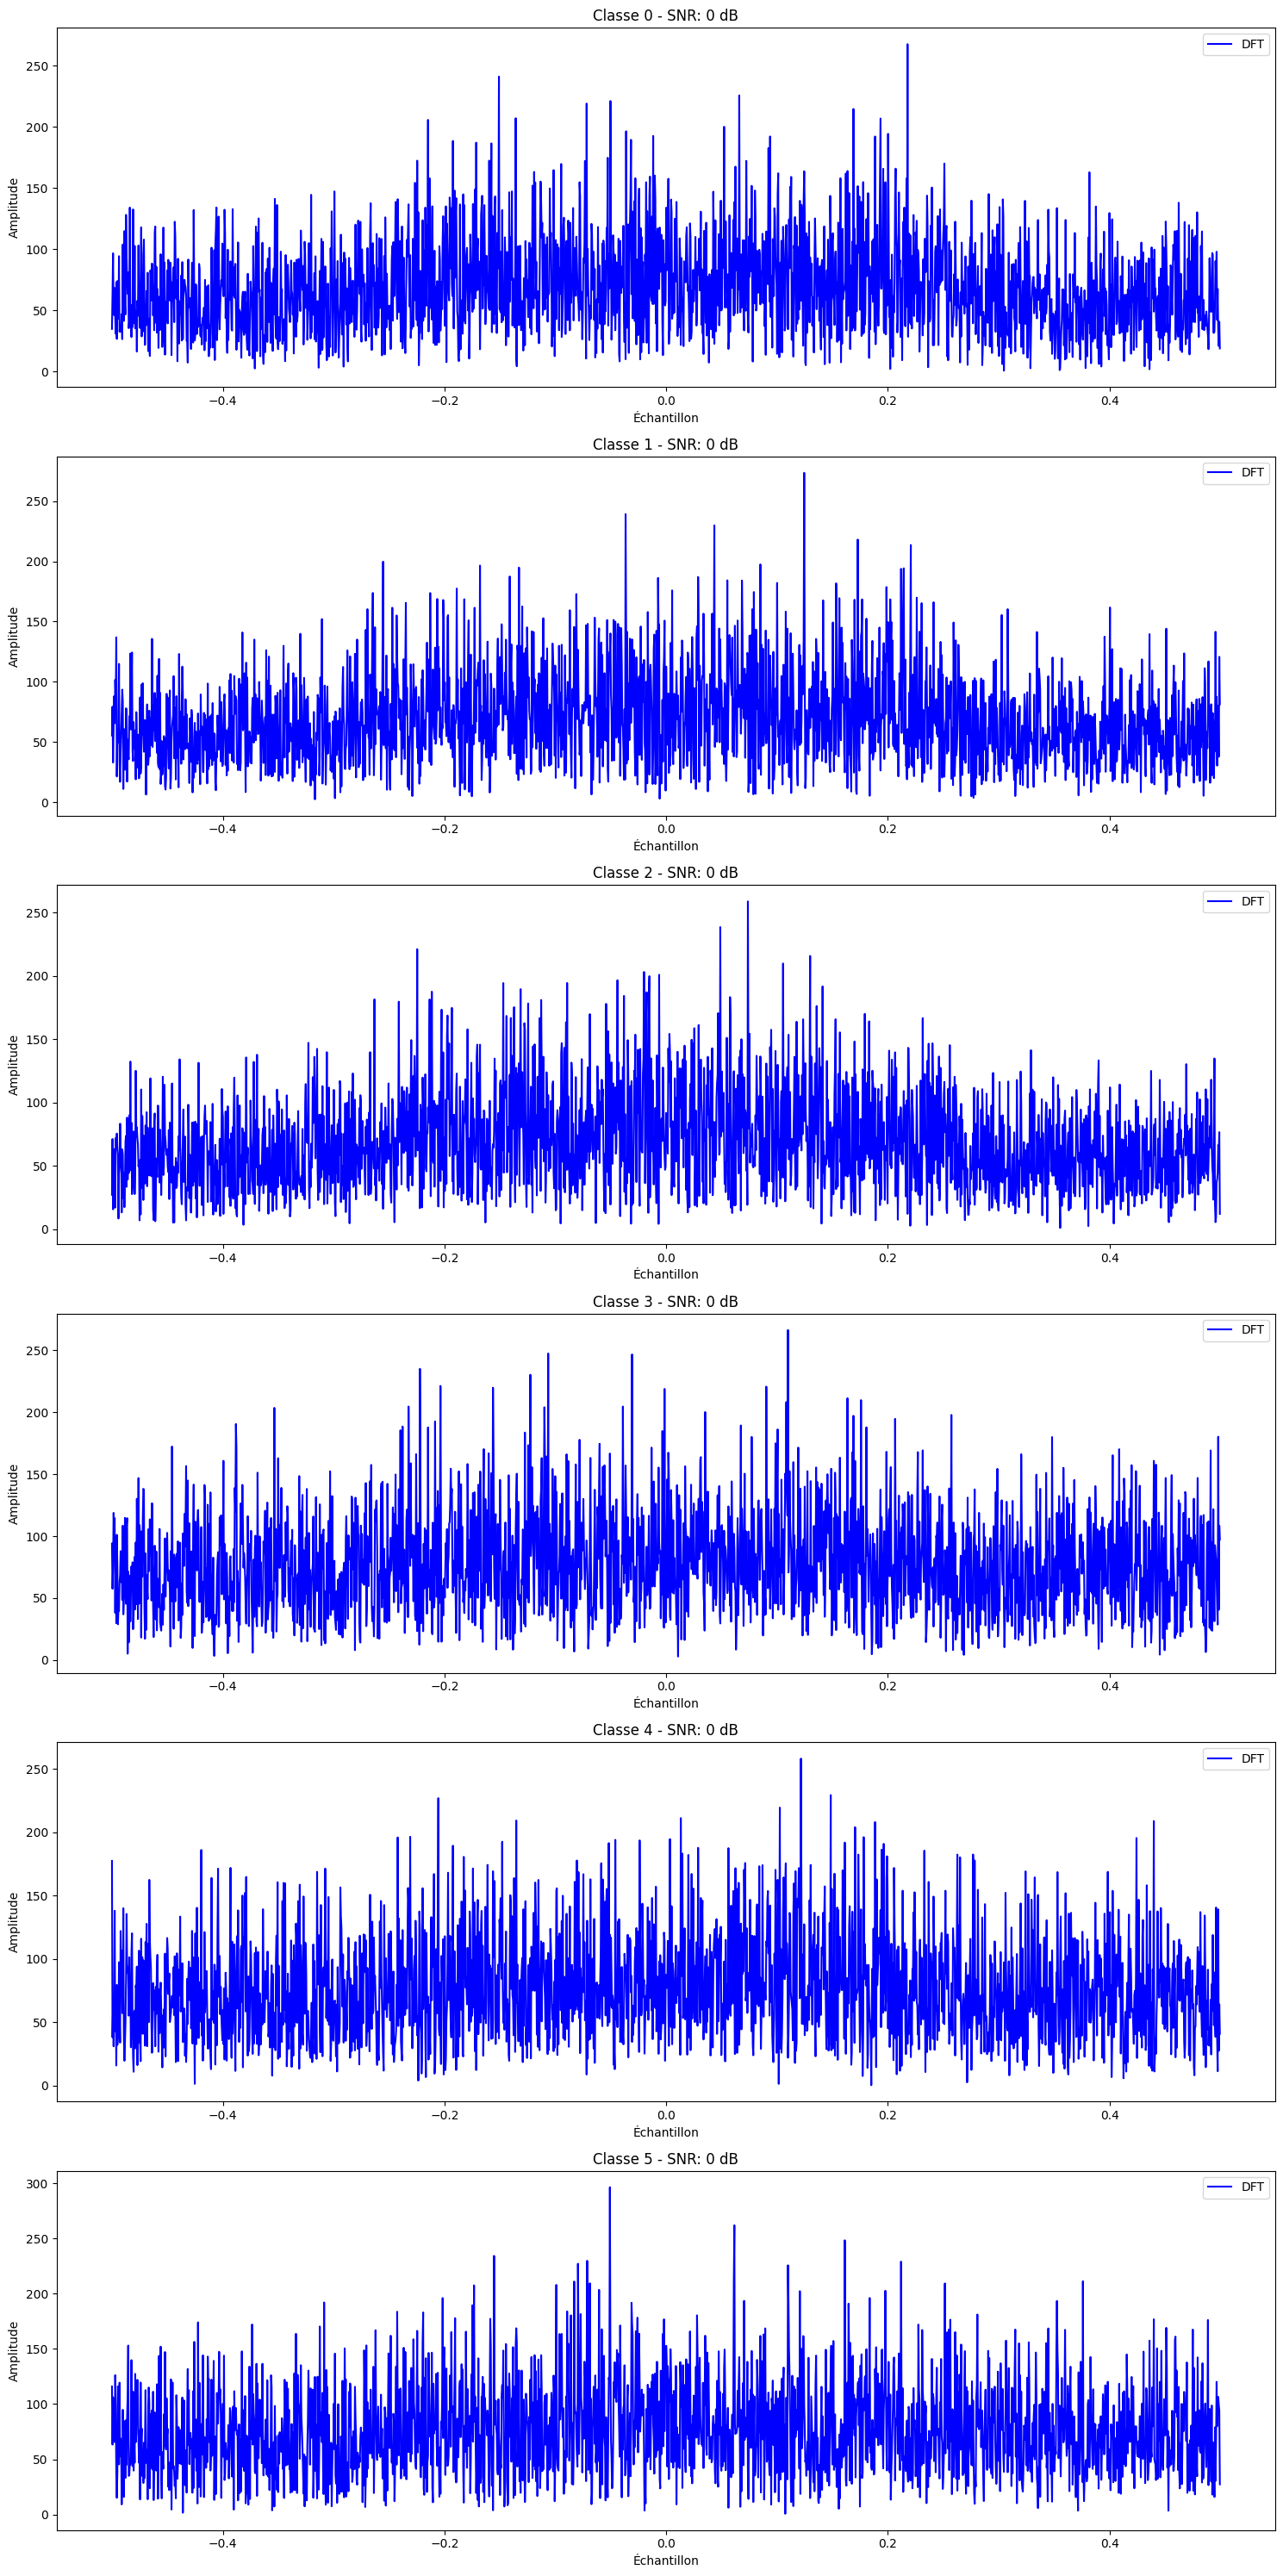

In [17]:
# Pour un SNR de 0 dB
plot_samples_from_each_class_freq(signals, labels_id, snr, sample_from_each_classes_SNR0)

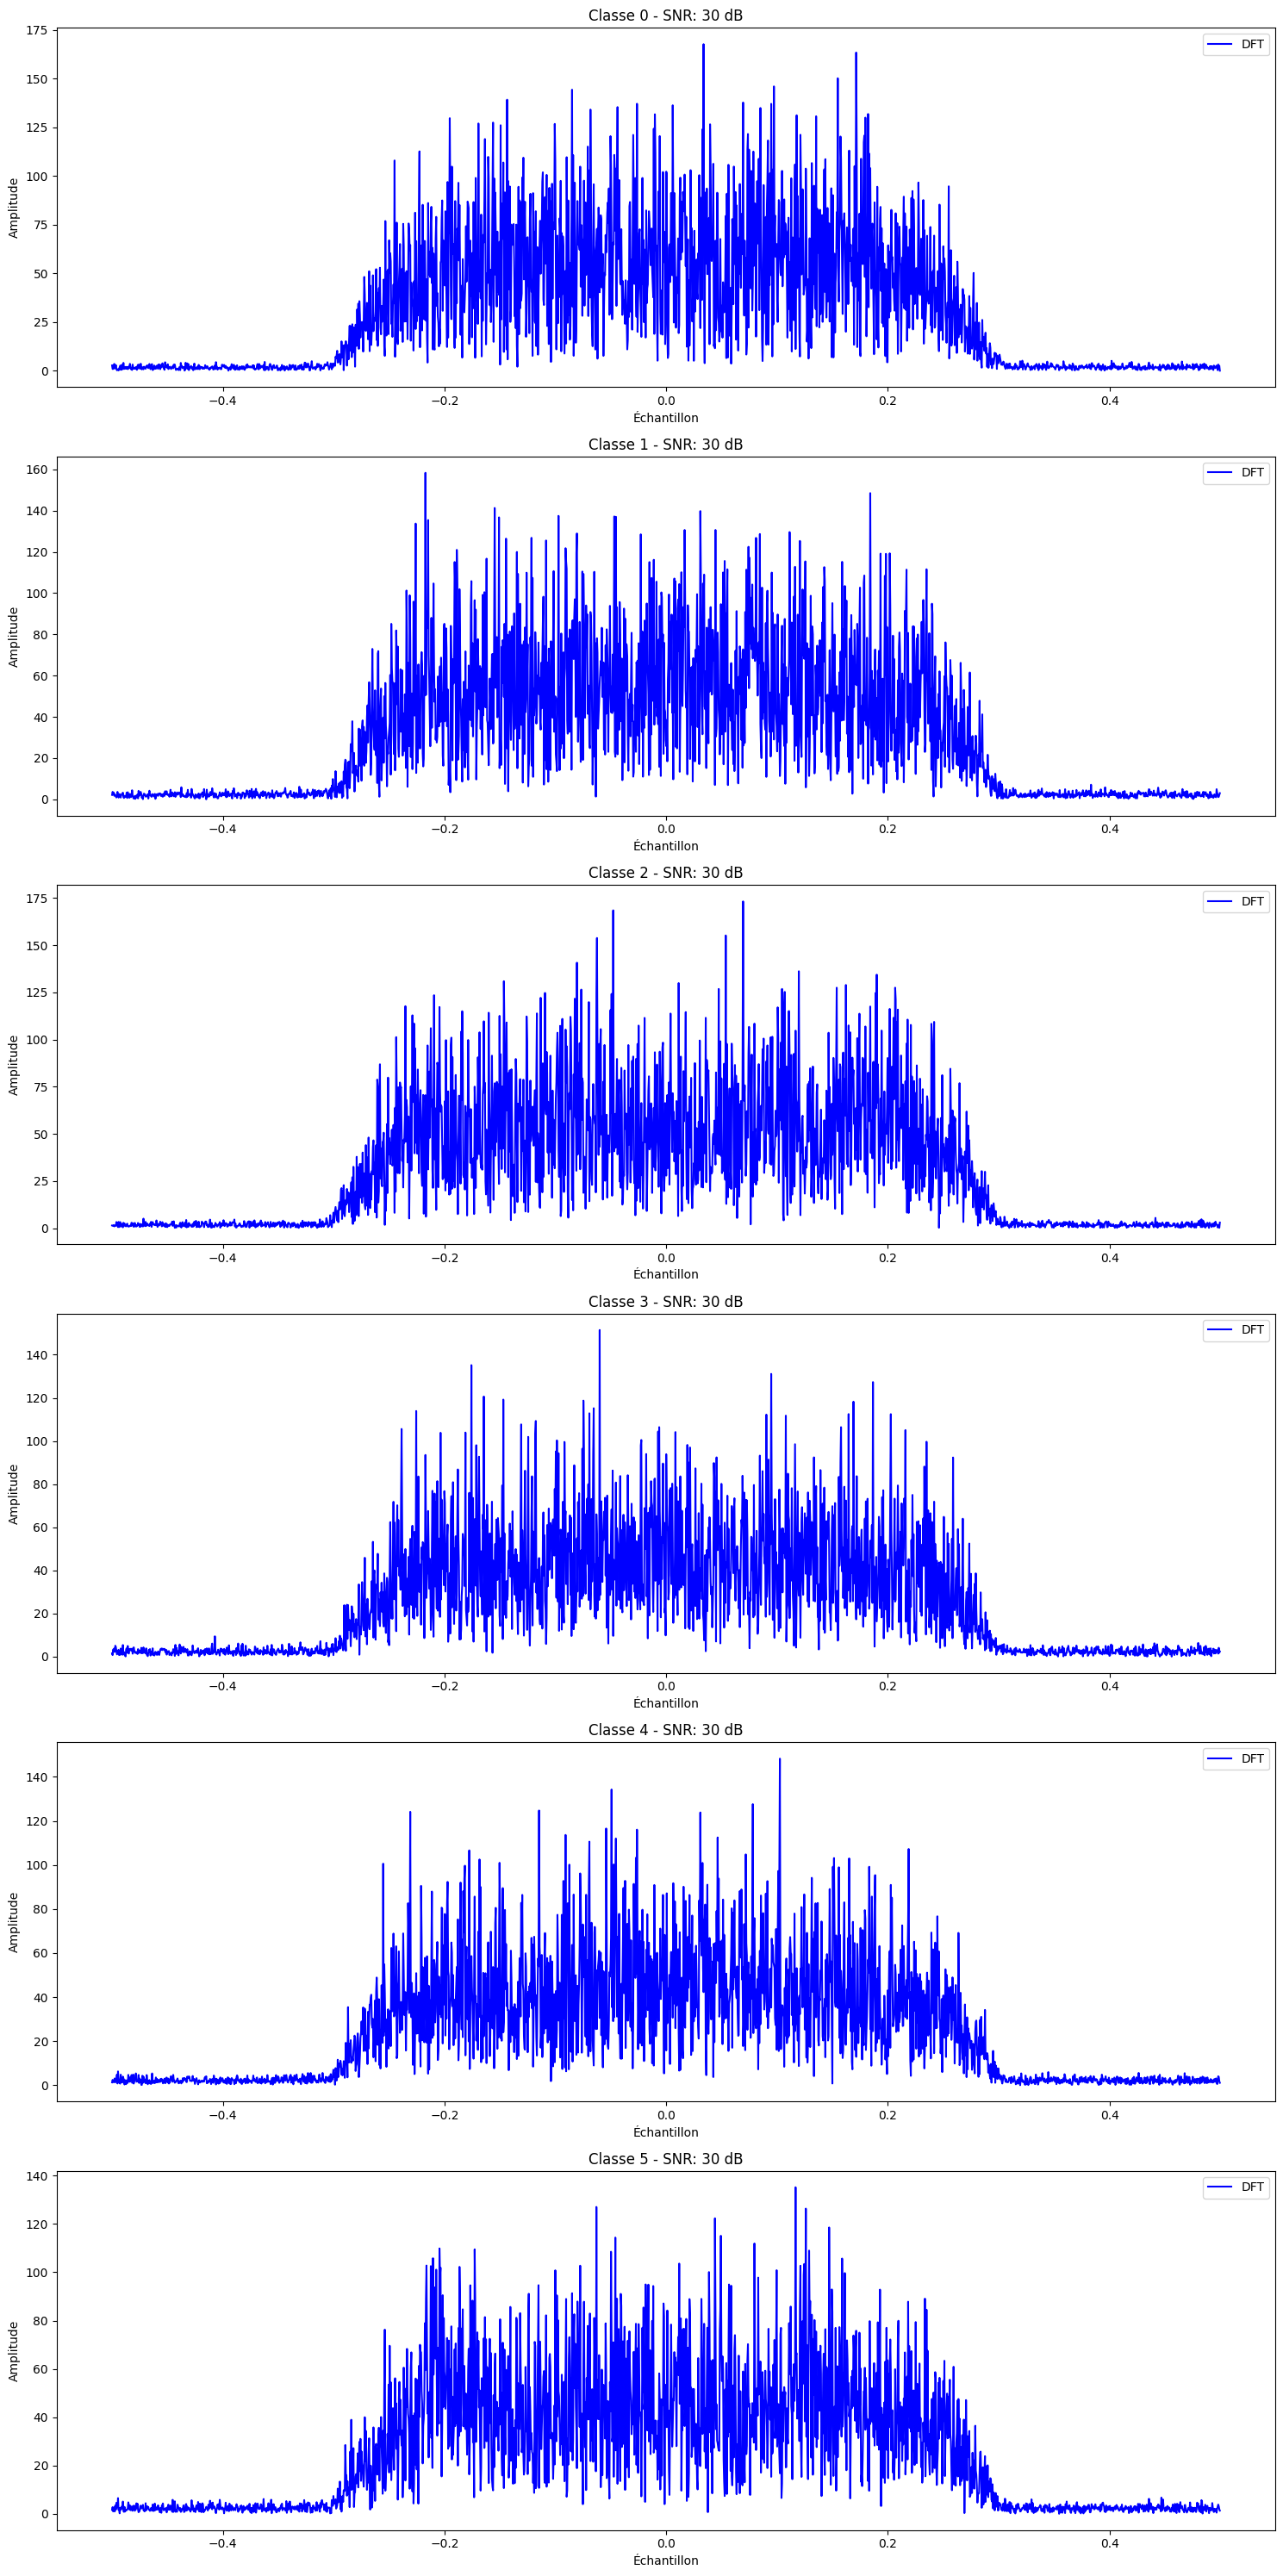

In [18]:
# Pour un SNR de 30 dB
plot_samples_from_each_class_freq(signals, labels_id, snr, sample_from_each_classes_SNR30)

Pour un SNR de 30 dB, on voit que l'ouverture fréquentielle du signal semble varier, de manière légère, entre chaque classe. mais, encore une fois, il est assez difficile de dire que cela est une caractéristique intrinsèque de chaque classe. On voit que l'ouverture fréquentielle des signaux ayant un SNR de 0 dB est beaucoup plus grande, à cause du bruit. D'un point de vue visuel, on pourrait se dire que toute les fréquences au-delà de 0.3 correspondent à du bruit.

## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones
    
Un dataset prend la forme
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici

In [19]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        super().__init__()
        self.path = path_to_data
        with h5py.File(self.path, 'r') as data:
            self.length = len(data["snr"])

    def __len__(self):
        return self.length

    def __getitem__(self,i):
        with h5py.File(self.path, 'r') as data:
            return torch.tensor(np.array(data['signaux'][i])).permute(1,0), int(data["labels"][i])



Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [20]:
dataset = MyDataset(_REP_PATH_ + 'train.hdf5')
print(f"Le premier signal de mon dataset à les dimensions {dataset[0][0].shape} et correspond à la classe {dataset[0][1]}")

Le premier signal de mon dataset à les dimensions torch.Size([2, 2048]) et correspond à la classe 4


Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset.
La cellule suivante donne un exemple d'utilisation

In [21]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset,
                        batch_size=10,
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size

In [22]:
dataloader = DataLoader(dataset,
                        batch_size=5,
                        shuffle=True
                       )
print(len(dataloader))

6000


## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce modèle doit comporter moins de 10000 paramètres libres.

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [23]:
# Pour ce modèle, on propose une architecture très simple, qui consiste en deux couches de convolution suivies d'une couche linéaire.
class dumb_model(torch.nn.Module):
    def __init__(self, initial_length, initial_nb_channel):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(initial_nb_channel,4, kernel_size=5)
        self.conv2 = torch.nn.Conv1d(4,6, kernel_size=3)
        self.pool = torch.nn.MaxPool1d(3)
        self.layer1 = torch.nn.Linear(6*226, 6)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = torch.log_softmax(x, dim=1)
        return x

Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées (test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point).

In [24]:
dmodel = dumb_model(2048,2)

input_sample_batchx, input_sample_batchy = next(iter(dataloader))

output = dmodel(input_sample_batchx)
print(output.shape)

torch.Size([5, 6])


La taille de l'output correspond bien à ce que l'on attend, à savoir, pour chaque signal, une "liste" de 6 éléments, qui correspondent à la log-probabilité que le signal appartient à ladite classe.

Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante :

>On a deux couches de convolution. Pour chaque couche, le nombre de paramètres est C_in x C_out x K + C_out (biais). Donc pour ces deux couches, le nombre de paramètres est 2x4x5+4x6x3 +10 = 122.
Le maxpooling s'applique deux fois, à chaque fois on divise par 3 la taille de la dernière dimension de nos tenseurs. Donc, en entrée de la couche dense, notre tenseur est de dimension 5 (taille du batch) x (6x226). En sortie, notre tenseur est de dimension 5 x 6. Il y a donc, pour la couche linéaire, (6x226) x 6 +6 (biais) = 8142. In fine, on a 8142 + 122 = 8 264 paramètres à apprendre.

In [25]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [26]:
print(count_n_param(dmodel))

8264


## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [27]:
# chemin vers les fichiers de train/test/validation
path_samples = _REP_PATH_ + 'samples.hdf5'
path_train = _REP_PATH_ + 'train.hdf5'
path_test = _REP_PATH_ + 'test.hdf5'
path_validation = _REP_PATH_ + 'validation.hdf5'

In [29]:
# Check if GPU is accessible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Size of the batches
batch_size = 10

# Creation of the datasets
train_data = MyDataset(path_train)
test_data = MyDataset(path_test)
valid_data = MyDataset(path_validation)

In [30]:
# Creation of the dataloaders
dataloader_train = DataLoader(train_data,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_test = DataLoader(test_data,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_valid = DataLoader(valid_data,
                        batch_size= batch_size,
                        shuffle=True
                       )


In [31]:
# Parameters of the model
model = dumb_model(2048,2)
loss = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 10

# Path to save the model
chemin_vers_sauvegarde_model = _REP_PATH_ + 'model/dumb_model.pth'


In [32]:
def pytorch_pipeline(device, model, train_data, validation_data, optimizer, criterion, n_epoch, path_save_model):

    model.to(device)

    for epoch in range(n_epoch):
        # Training phase
        model.train()
        train_loss = 0
        correct_pred = 0
        all_pred = 0
        for batch_x, batch_y in train_data:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            pred_y = model(batch_x)
            loss = criterion(pred_y, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct_pred+= (torch.max(pred_y, 1)[1] ==  batch_y).sum().item()
            all_pred+= batch_y.size(0)
        print(f"TRAIN : epoch [{epoch+1}/{n_epoch}] - Loss : {train_loss/len(train_data):.2f} - Accuracy : {correct_pred/all_pred:.2f} ",  end="\t")

        # Validation phase
        model.eval()
        valid_loss = 0
        correct_pred = 0
        all_pred = 0
        for batch_x,batch_y in validation_data:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            with torch.no_grad():
                pred_y = model(batch_x)
                loss = criterion(pred_y, batch_y)
                valid_loss+= loss.item()
                correct_pred+= (torch.max(pred_y, 1)[1] ==  batch_y).sum().item()
                all_pred+= batch_y.size(0)
        print(f"VALIDATION : epoch [{epoch+1}/{n_epoch}] - Loss : {valid_loss/len(validation_data):.2f} - Accuracy : {correct_pred/all_pred:.2f} ")
    torch.save(model, chemin_vers_sauvegarde_model)

In [ ]:
pytorch_pipeline(device, model, dataloader_train, dataloader_valid, optimizer, loss, n_epochs, chemin_vers_sauvegarde_model)

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [144]:
model = torch.load(_REP_PATH_ + 'dumb_model.pth', map_location = device)

<ipython-input-144-ff70338dc19c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(_REP_PATH_ + 'dumb_model.pth', map_location = device)


In [145]:
model.to(device)
sample_datax, sample_datay  = MyDataset(path_samples)[0][0].unsqueeze(0), MyDataset(path_samples)[0][1]
sample_datax = sample_datax.to(device)
pred_y = model(sample_datax)
print(f"La classe prédite par notre modèle est : {int(torch.argmax(pred_y, 1))}")
print(f"La vraie classe est : {sample_datay}")

La classe prédite par notre modèle est : 1
La vraie classe est : 2


### Résultats de la `Baseline`

>Le modèle `baseline` permet de nous donner des métriques de base afin d'évaluer la performance des prochains modèle, plus volumineux (en terme de paramètres) et/ou plus complèxe. Afin d'avoir des seuils de performance, nous allons calculer l'accuracy sur l'ensemble de données de test, représenter la distribution des accuracy en fonction du SNR et enfin les matrices de confusions.

In [146]:
## Fonction pour le calcul de l'accuracy sur l'ensemble de test

def calculate_accuracy(model, dataloader, device =torch.device("cuda" if torch.cuda.is_available() else "cpu") , num_classes = 6, display_every=100, affichage = True):
    """
    Calcule l'accuracy pour un dataloader de test multiclass et affiche la progression tous les `display_every` batches.

    Args:
        model (torch.nn.Module): Le modèle à évaluer.
        dataloader (torch.utils.data.DataLoader): Le dataloader contenant les données de test.
        device (torch.device): Le device (CPU ou GPU) utilisé pour les calculs.
        num_classes (int): Nombre de classes.
        display_every (int): Intervalle pour afficher les progrès (en nombre de batches).

    Returns:
        tuple: L'accuracy moyenne finale et une liste des accuracies batch par batch.
    """
    # Initialiser le calcul de l'accuracy avec torchmetrics
    accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

    # Basculer le modèle en mode évaluation
    model.eval()

    batch_accuracies = []  # Pour stocker les accuracies par batch
    total_batches = len(dataloader)  # Nombre total de batches

    # Accumuler l'accuracy sur tous les batches
    with torch.no_grad(): # On ne s'intéresse pas au calcul des gradients
        for batch_idx, batch in enumerate(dataloader):
            # Extraire les données et les labels
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Prédictions du modèle
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)  # Indices des valeurs maximales

            # Mettre à jour l'accuracy avec les batchs actuels
            accuracy_metric.update(predictions, targets)

            # Calculer l'accuracy courante
            current_accuracy = accuracy_metric.compute().item()
            batch_accuracies.append(current_accuracy)

            # Afficher la progression tous les `display_every` batches
            if (batch_idx + 1) % display_every == 0 or batch_idx == total_batches - 1:
                print(f"Batch {batch_idx + 1}/{total_batches} - Current Accuracy: {current_accuracy:.4f}")

    # Calculer l'accuracy finale
    final_accuracy = accuracy_metric.compute().item()
    print(f"\nFinal Accuracy: {final_accuracy:.4f}")

    # Tracer l'évolution de l'accuracy
    if affichage :
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, total_batches + 1), batch_accuracies, label="Batch Accuracy", marker="*")
        plt.axhline(y=final_accuracy, color='red', linestyle='--', label=f"Final Accuracy: {final_accuracy:.4f}")
        plt.xlabel("Batch Index")
        plt.ylabel("Accuracy")
        plt.title("Evolution de l'accuracy avec les batches")
        plt.legend()
        plt.grid(True)
        plt.show()

    return final_accuracy, batch_accuracies


Batch 100/1000 - Current Accuracy: 0.5940
Batch 200/1000 - Current Accuracy: 0.6075
Batch 300/1000 - Current Accuracy: 0.5980
Batch 400/1000 - Current Accuracy: 0.6030
Batch 500/1000 - Current Accuracy: 0.6008
Batch 600/1000 - Current Accuracy: 0.6015
Batch 700/1000 - Current Accuracy: 0.6079
Batch 800/1000 - Current Accuracy: 0.6124
Batch 900/1000 - Current Accuracy: 0.6104
Batch 1000/1000 - Current Accuracy: 0.6121

Final Accuracy: 0.6121


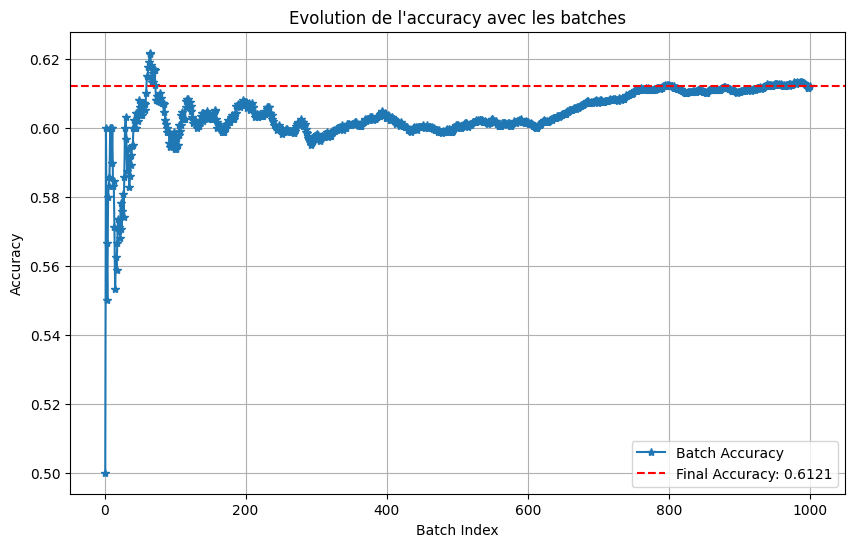

In [147]:
## Calcul de l'accuracy sur l'ensemble de test
dumb_model_accuracy, _ = calculate_accuracy(model, dataloader_test)

> Sur l'ensemble de test, notre modèle `Baseline` atteint une `accuracy = 0.6048`. Rappelons que ce modèle se base uniquement sur `8264` paramètres induis par deux couches de convolutions et une couche linéaire.

In [148]:
## Fonction pour le calcul et l'affichage de l'accuracy par classe de SNR

def accuracy_by_SNR(data_path, model, device =torch.device("cuda" if torch.cuda.is_available() else "cpu") , num_classes = 6, affichage = True ) :

    # Charger les données
    data = h5py.File(data_path, 'r')

    signals = np.array(data['signaux'])  # Signaux
    snr = np.array(data['snr'])          # SNR
    labels_id = np.array(data['labels']) # Labels

    # Convertir en tenseurs PyTorch
    signals_tensor = torch.tensor(signals, dtype=torch.float32)
    snr_tensor = torch.tensor(snr, dtype=torch.float32)
    labels_tensor = torch.tensor(labels_id, dtype=torch.long)

    # Classes uniques de SNR
    snr_classes = torch.unique(snr_tensor)

    # Initialiser un dictionnaire pour stocker l'accuracy par classe de SNR
    accuracy_per_snr = {}

    # On s'assure que le modèle est bien en mode évalution
    model.eval()

    # Device (GPU ou CPU)
    model.to(device)

    # Calcul de l'accuracy pour chaque classe de SNR
    for snr_class in snr_classes:
        # Sélectionner les indices pour cette classe de SNR
        indices = (snr_tensor == snr_class)

        # Extraire les signaux et labels correspondants
        signals_class = signals_tensor[indices].permute(0,2,1).to(device)
        labels_class = labels_tensor[indices].to(device)

        # Créer un DataLoader pour cette classe de SNR avec le batch_size spécifié
        dataset = TensorDataset(signals_class, labels_class)
        dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

        correct_pred = 0
        all_pred = 0

        for batch_x,batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            # Prédictions du modèle
            with torch.no_grad():
                outputs = model(batch_x)
                correct_pred += (torch.max(outputs, 1)[1] ==  batch_y).sum().item()
                all_pred += batch_y.size(0)

        # Calcul de l'accuracy pour cette classe
        accuracy_per_snr[snr_class.item()] = correct_pred/all_pred

    # Créer un barplot pour représenter les accuracies par classe de SNR
    snr_classes_list = list(accuracy_per_snr.keys())
    accuracies = list(accuracy_per_snr.values())


    if affichage :

        plt.figure(figsize=(10, 6))
        bars = plt.bar(snr_classes_list, accuracies, color='skyblue', edgecolor='black')
        plt.xlabel("Classes de SNR")
        plt.ylabel("Accuracy")
        plt.title("Accuracy par classe de SNR")
        plt.xticks(snr_classes_list, [f"SNR={s}" for s in snr_classes_list], rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{accuracy:.3f}",
                     ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')
        plt.tight_layout()
        plt.show()

    return accuracy_per_snr

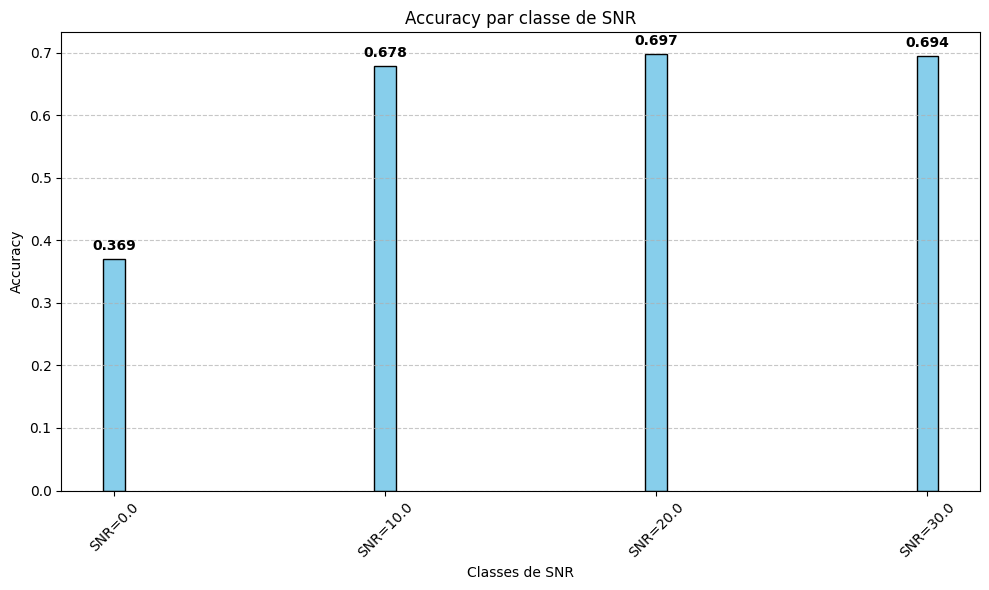

In [149]:
dumb_model_accuracy_per_snr = accuracy_by_SNR(path_test, model)

> Dans le cas de la `Baseline`, nous observons que la classe `SNR = 0` a une `accuracy` de `0.369`, ce qui est bien inférieur à l'accuracy des autres classes de SNR, qui sont plutôt autour de `0.69`. Notre modèle `Baseline` a donc du mal à classer les signaux lorsque le bruit est très élevé.

In [150]:
# On va maintenant afficher les matrices de confusions pour le modèle baseline
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_matrix, labels, ax, title="Confusion Matrix"):
    """ Affiche la matrice de confusion sous forme de heatmap. """
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    ax.grid(False)

def confusion(data_path, model, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), num_classes=6, affichage=True):
    data = h5py.File(data_path, 'r')

    signals = np.array(data['signaux'])
    snr = np.array(data['snr'])
    labels_id = np.array(data['labels'])

    signals_tensor = torch.tensor(signals, dtype=torch.float32)
    snr_tensor = torch.tensor(snr, dtype=torch.float32)
    labels_tensor = torch.tensor(labels_id, dtype=torch.long)

    snr_classes = torch.unique(snr_tensor)

    # Dic pour stocker les snr
    confusion_matrices_per_snr = {}

    # Début des calculs
    model.eval()
    model.to(device)

    for snr_class in snr_classes:
        indices = (snr_tensor == snr_class)

        signals_class = signals_tensor[indices].permute(0, 2, 1).to(device)
        labels_class = labels_tensor[indices].to(device)

        # Créer un DataLoader pour cette classe de SNR avec le batch_size spécifié
        dataset = TensorDataset(signals_class, labels_class)
        dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

        conf_by_batch = np.zeros((num_classes, num_classes), dtype=int)

        for batch_x,batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            with torch.no_grad():
                outputs = model(batch_x)
                _, predictions = torch.max(outputs, 1)

            # Calcul de la matrice de confusion pour chaque batch
            conf_by_batch += confusion_matrix(batch_y.cpu(), predictions.cpu(), labels=np.arange(num_classes))


        confusion_matrices_per_snr[snr_class.item()] = conf_by_batch

    # Calcul de la matrice de confusion pour toute les classes
    cm_all = sum(confusion_matrices_per_snr.values())

    # Affichage
    if affichage:
        fig, axes = plt.subplots(3, 2, figsize=(12, len(snr_classes) * 3))
        axes = axes.flatten()

        # Affichage pour chaque classe de SNR
        for i, snr_class in enumerate(snr_classes):

            plot_confusion_matrix(confusion_matrices_per_snr[snr_class.item()],
                                  labels=[f"Class {i}" for i in range(num_classes)],
                                  title=f"Confusion Matrix SNR = {snr_class.item()}",
                                  ax=axes[i])

        # Affichage pour le dataset complet
        plot_confusion_matrix(cm_all,
                              labels=[f"Class {i}" for i in range(num_classes)],
                              title="Confusion Matrix - Dataset Complet",
                              ax=axes[4])

        axes[5].set_visible(False)

        plt.tight_layout()
        plt.show()

    return confusion_matrices_per_snr, cm_all


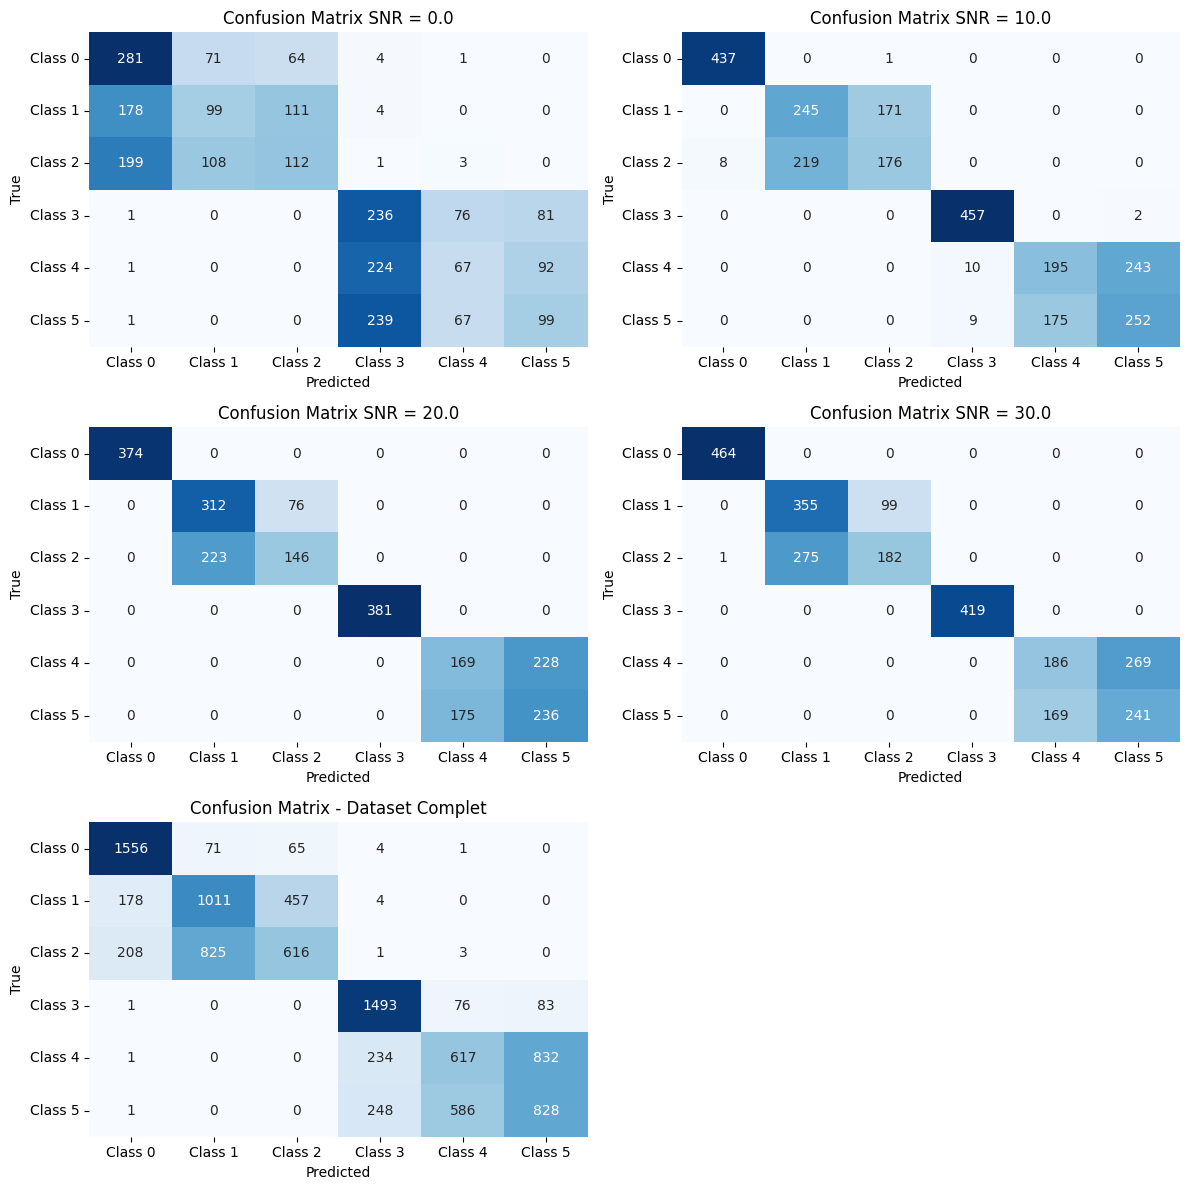

In [151]:
_, _ = confusion(path_test, model)

>Ces matrices de confusion nous donnent beaucoup d'informations vis à vis des erreurs par classes et par SNR :
>- Pour le `SNR = 0`, nous observons que les erreurs sont concentrées autours de deux clusters. En effet, les classes `0, 1, 2` ont seulement des erreurs entre elles (de même pour les classes `3,4,5`). De plus, nous pouvons observé que les erreurs de prédictions intra-classes sont uniformément répartis, par exemple : il y a pour la prédiction de la classe 3, 236 signaux qui appartiennent bien à la classe 3, 224 à la classe 4 et 239 à la classe 5. Cette observation peut se faire pour l'ensemble des classes prédites.
>
>- Pour les `SNR = 10, 20, 30`, Nous pouvons observer les mêmes patern : les classes `0 et 3` sont toutes deux bien prédites tandis que l'on a des erreurs sur les classes `1, 2` et `4, 5` respectivement.
>
>Dans le dataset complet, nous pouvons observer les mêmes partern vu précedement, avec beaucoup d'erreurs entre les classes `0, 1, 2` et `3, 4, 5`.

## Entraînement de réseaux de neurones
>Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.
>
>Dans un deuxième temps (facultatif), si vous le souhaitez vous pouvez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.


### Réseaux de neurones convolutifs et récurrents

#### Premier réseau de neurones

>Ce premier réseau de neurones combine des couches convolutives (CNN) pour extraire des caractéristiques locales et des couches récurrentes (GRU) pour capturer des dépendances à long terme. Le réseau commence par trois couches convolutives (avec des tailles de noyau de 7 et 5) qui apprennent des représentations à différentes échelles de la séquence d'entrée. Chaque couche convolutive est suivie d'une normalisation (BatchNorm) pour améliorer la stabilité. Après la troisième couche de convolution, une couche de max-pooling est utilisée pour réduire la taille des représentations tout en conservant les informations importantes.
>
>Les sorties des convolutions sont ensuite réorganisées pour être adaptées à l'entrée de la couche GRU (Gated Recurrent Unit), qui traite les données séquentielles. Le réseau GRU est constitué de 3 couches, et seule la dernière hidden layer est utilisée comme entrée pour les couches entièrement connectées suivantes. Cela permet au modèle de résumer l'information pertinente à travers toute la séquence. Les couches linéaires (fully connected) prennent la sortie du GRU et la réduisent à un vecteur de dimension 32, qui est ensuite projeté sur un espace de sortie de 6 classes. Enfin, une fonction log_softmax est appliquée pour obtenir les probabilités normalisées, utiles pour la classification multiclasses. Ce modèle combine ainsi les avantages des CNN pour l'extraction de caractéristiques locales et des GRU pour modéliser les relations temporelles dans les données.
>
>Dans ce modèle, nous placons les couches de convolutions avant la couche récurrente.

In [152]:
class CNN_GRU(torch.nn.Module):
  def __init__(self, initial_length, initial_nb_channel):
    super().__init__()
    self.conv1 = torch.nn.Conv1d(initial_nb_channel,16, kernel_size=7) # input: [B,2, 2048]
    self.bn1 = torch.nn.BatchNorm1d(16)
    self.conv2 = torch.nn.Conv1d(16, 64, kernel_size=5) # input : [B,16,2048]
    self.bn2 = torch.nn.BatchNorm1d(64)
    self.conv3 = torch.nn.Conv1d(64, 128, kernel_size=5) # input : [B,64,2048]
    self.bn3 = torch.nn.BatchNorm1d(128)
    self.pool = torch.nn.MaxPool1d(2) # input : [B,128,2048]
    self.gru1 = torch.nn.GRU(128, 64, num_layers=3, batch_first=True) # input : [B,128,1024]
    self.fc1 = torch.nn.Linear(64, 32) # input : [B, 64] -> We only take the last hidden state of the last layer in the GRU
    self.fc2 = torch.nn.Linear(32, 6) # input : [B, 32]
    self.activation = torch.nn.ReLU()

  def forward(self, x):
    x = self.activation(self.bn1(self.conv1(x)))
    x = self.activation(self.bn2(self.conv2(x)))
    x = self.pool(self.activation(self.bn3(self.conv3(x))))
    x = x.permute(0, 2, 1)
    _, h_n = self.gru1(x)
    h_n = h_n[-1]
    x = self.activation(self.fc1(h_n))
    x = self.fc2(x)
    x = torch.log_softmax(x, dim=1)
    return x


In [153]:
# Parameters of the model
model = CNN_GRU(2048,2)
loss = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 10

# Path to save the model
chemin_vers_sauvegarde_model = _REP_PATH_ + 'CNN_GRU.pth'

In [154]:
for name, param in model.named_parameters():
    print(f"Paramètre: {name}, Taille: {param.size()}, Nombre d'éléments: {param.numel()}")
print(f"Total des paramètres: {count_n_param(model)}")

Paramètre: conv1.weight, Taille: torch.Size([16, 2, 7]), Nombre d'éléments: 224
Paramètre: conv1.bias, Taille: torch.Size([16]), Nombre d'éléments: 16
Paramètre: bn1.weight, Taille: torch.Size([16]), Nombre d'éléments: 16
Paramètre: bn1.bias, Taille: torch.Size([16]), Nombre d'éléments: 16
Paramètre: conv2.weight, Taille: torch.Size([64, 16, 5]), Nombre d'éléments: 5120
Paramètre: conv2.bias, Taille: torch.Size([64]), Nombre d'éléments: 64
Paramètre: bn2.weight, Taille: torch.Size([64]), Nombre d'éléments: 64
Paramètre: bn2.bias, Taille: torch.Size([64]), Nombre d'éléments: 64
Paramètre: conv3.weight, Taille: torch.Size([128, 64, 5]), Nombre d'éléments: 40960
Paramètre: conv3.bias, Taille: torch.Size([128]), Nombre d'éléments: 128
Paramètre: bn3.weight, Taille: torch.Size([128]), Nombre d'éléments: 128
Paramètre: bn3.bias, Taille: torch.Size([128]), Nombre d'éléments: 128
Paramètre: gru1.weight_ih_l0, Taille: torch.Size([192, 128]), Nombre d'éléments: 24576
Paramètre: gru1.weight_hh_l0

> Ce modèle à bien plus de paramètre que la `Baseline` utilisée plus haut. Ce modèle `CNN_GRU` a `136374` paramètres, principalements localisé dans la dernière couche de convolution et dans la couche récurrente `gru1`.

In [155]:
# Entraînement du modèle
#pytorch_pipeline(device, model, dataloader_train, dataloader_valid, optimizer, loss, n_epochs, chemin_vers_sauvegarde_model)

In [156]:
# chargement du modèle CNN_GRU
CNN_GRU_model = torch.load(chemin_vers_sauvegarde_model)

<ipython-input-156-c7619936fe5f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_GRU_model = torch.load(chemin_vers_sauvegarde_model)


Batch 100/1000 - Current Accuracy: 0.6010
Batch 200/1000 - Current Accuracy: 0.6125
Batch 300/1000 - Current Accuracy: 0.5980
Batch 400/1000 - Current Accuracy: 0.6000
Batch 500/1000 - Current Accuracy: 0.5986
Batch 600/1000 - Current Accuracy: 0.6028
Batch 700/1000 - Current Accuracy: 0.6020
Batch 800/1000 - Current Accuracy: 0.6041
Batch 900/1000 - Current Accuracy: 0.6026
Batch 1000/1000 - Current Accuracy: 0.6036

Final Accuracy: 0.6036


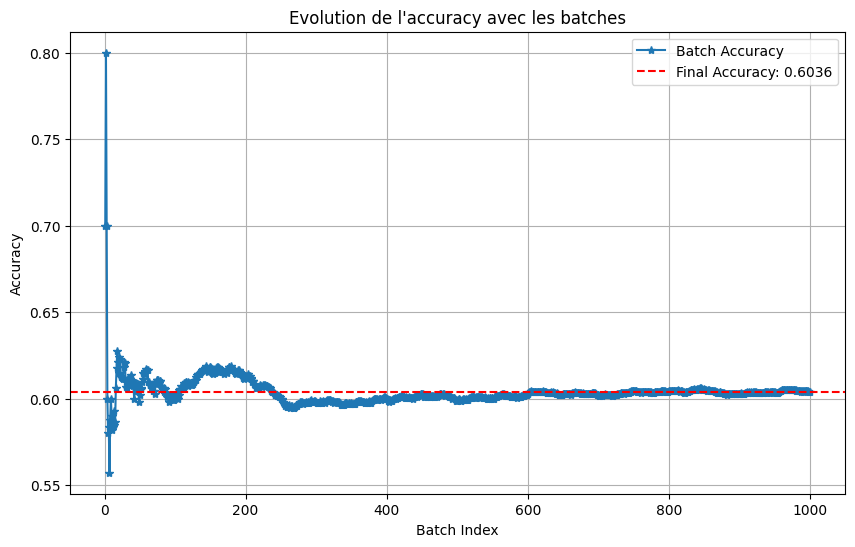

In [157]:
## Calcul de l'accuracy sur l'ensemble de test
CNN_GRU_accuracy, _ = calculate_accuracy(CNN_GRU_model, dataloader_test)

>Même s'il a plus de paramètres, ce réseau de neurones obtient une accuracy moins bonne que celle du modèle `Baseline`. Cela peut être dû au fait que la couche de convolution se situe avant la couche récurrente. En effet, la couche de convolution permet de capturer des informations locales, tandis que la couche récurrente permet de traiter des informations globales. Mettre la couche récurrente après la couche de convolution revient donc à regarder des informations globales issues de jeux d'informations locales.

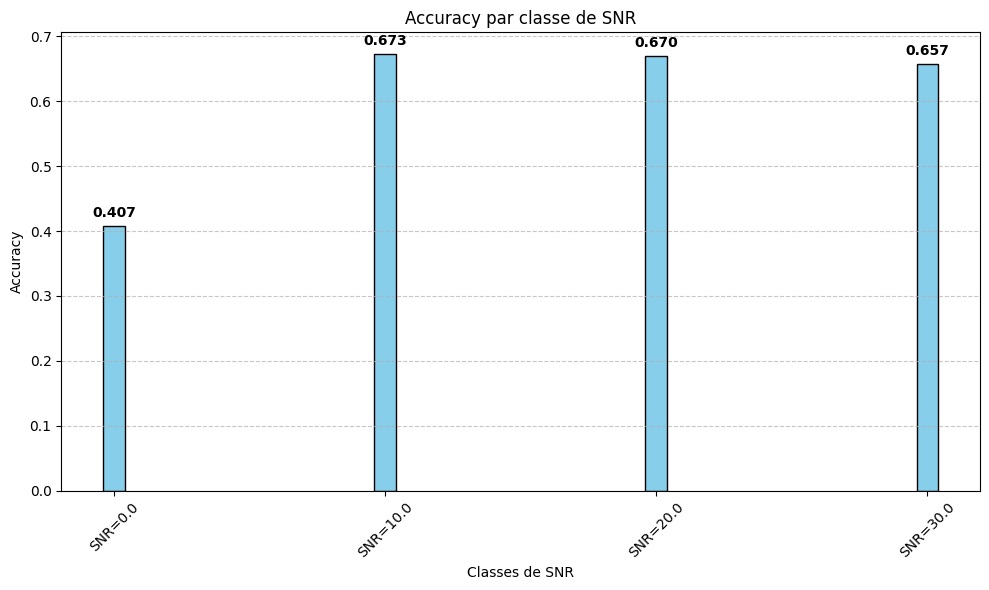

In [158]:
# Observation de l'accuracy par SNR
CNN_GRU_accuracy_per_snr = accuracy_by_SNR(path_test, CNN_GRU_model)

>Encore une fois, la classe `SNR = 0` est celle qui génère le plus d'erreurs dans nos prédictions, avec une accuracy de `0.407`, tandis que les autres classes sont, cette fois, autour de `0.67`.

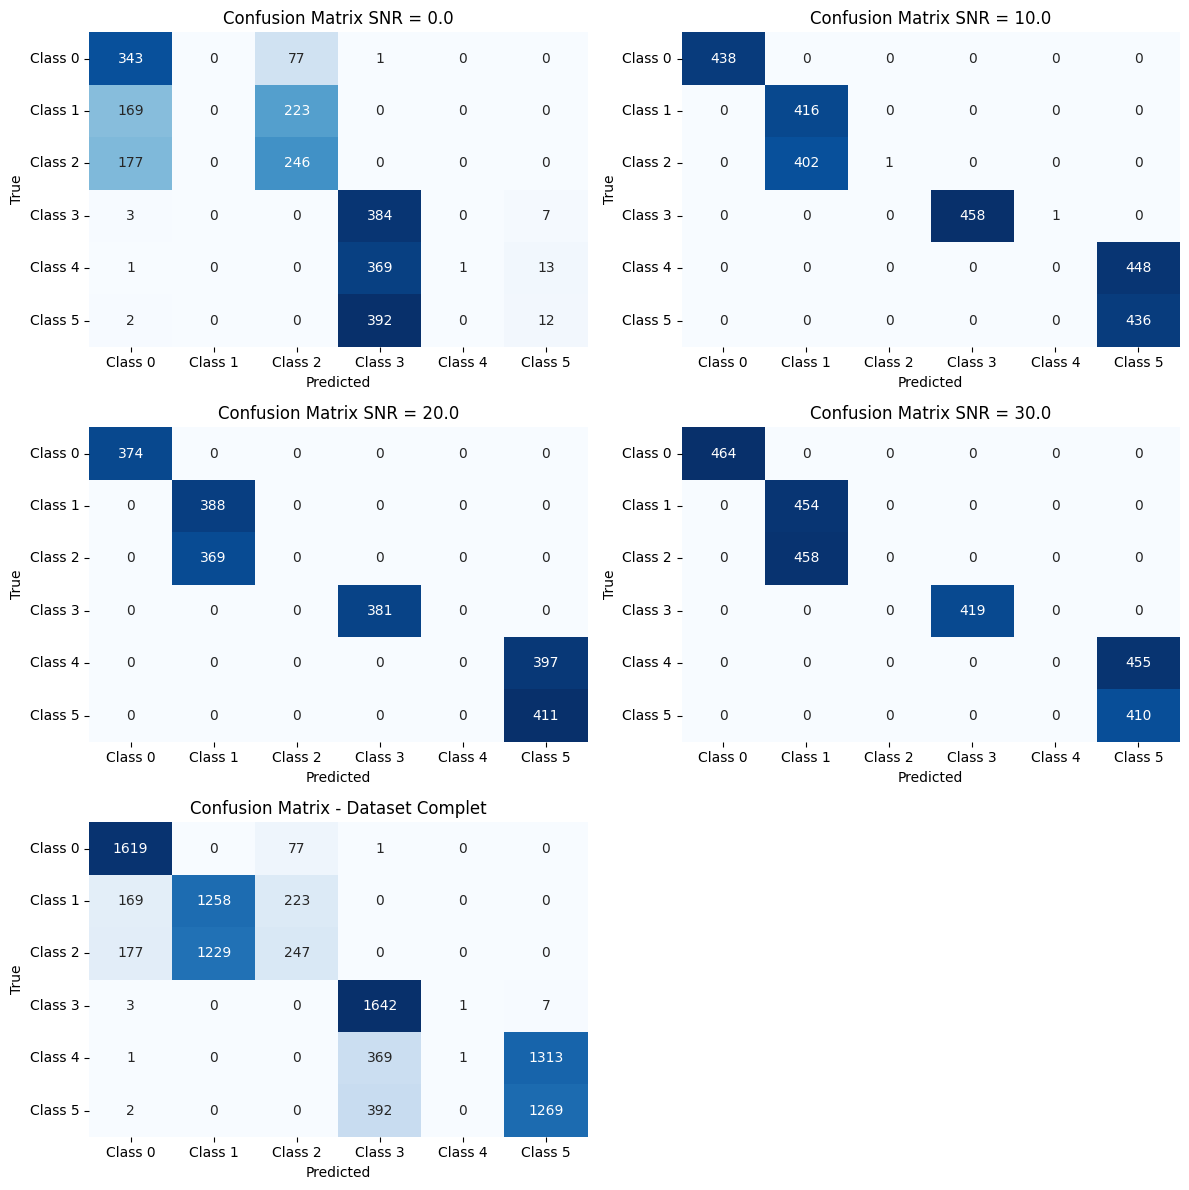

In [159]:
## Matrice de confusion par SNR
_, _ = confusion(path_test, CNN_GRU_model)

>Dans le cadre de ce modèle, nous pouvons observer des informations importantes et intéressantes :
>Le modèle est aveugle sur la classe 4 quelques soit le `SNR` tandis qu'il l'est pour les classes `2 et 1` suivant le `SNR`.
>
>La structure de cluster d'erreur est la encore observable avec des erreurs pour les classes `0, 1, 2` entre elles (respectivement `3, 4, 5`).
>
>Malgré une augmentation du nombre de paramètre, le modèle sous performe par rapport à la `Baseline`

#### Second réseau de neurones

>Le réseau de neurones `GRU_CNN` est une architecture hybride combinant des couches récurrentes (GRU), des couches convolutives (CNN) et des couches entièrement connectées (FC). L’architecture commence par deux couches GRU (Gated Recurrent Units) avec des dimensions cachées de 64 et 128, permettant de capturer les dépendances "temporelles" dans les données. L’utilisation des couches récurrentes avant les couches convolutiolutives est cruciale : elle permet de résumer les informations globales dans des représentations compactes avant d’extraire des caractéristiques locales via les convolutions.
>
>Une fois les sorties des GRU obtenues, elles sont réorganisées pour être traitées par deux couches convolutives 1D (Conv1D), accompagnées de normalisations (BatchNorm1d) pour stabiliser l’entraînement et d’une activation LeakyReLU plus smooth que la fonction ReLu. Ces couches extraient des caractéristiques locales pertinentes dans l’espace des canaux, et une opération de max pooling réduit leur taille tout en conservant les informations les plus importantes.
>
>La sortie des couches CNN est aplatie et traitée par des couches entièrement connectées. Une première couche dense réduit les dimensions à 128 neurones, et la couche finale mappe les données sur 6 classes. Une régularisation est assurée par une couche dropout, et la fonction de log-softmax en sortie génère des probabilités log-scalées pour la classification multi-classes.

In [160]:
class GRU_CNN(torch.nn.Module):
    def __init__(self, initial_length, initial_nb_channel):
        super(GRU_CNN, self).__init__()
        self.gru1 = torch.nn.GRU(initial_nb_channel, 64, batch_first=True)
        self.gru2 = torch.nn.GRU(64, 128, batch_first=True)
        self.conv1 = torch.nn.Conv1d(128, 64, kernel_size=13)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.conv2 = torch.nn.Conv1d(64, 32, kernel_size=9)
        self.bn2 = torch.nn.BatchNorm1d(32)
        self.pool = torch.nn.MaxPool1d(2,2)
        self.fc1 = torch.nn.Linear(32448, 128)
        self.fc2 = torch.nn.Linear(128, 6)
        self.activation = torch.nn.LeakyReLU(0.1)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x):
        x = x.permute(0,2,1)
        gru_out1, _ = self.gru1(x)
        gru_out2, _ = self.gru2(gru_out1)
        x = gru_out2.permute(0, 2, 1)
        x = self.activation(self.conv1(x))
        x = self.bn1(x)
        x = self.activation(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        # Output
        output = torch.log_softmax(x, dim=1)

        return output


In [161]:
model_gru_cnn = GRU_CNN(2048,2)
print(model_gru_cnn)

GRU_CNN(
  (gru1): GRU(2, 64, batch_first=True)
  (gru2): GRU(64, 128, batch_first=True)
  (conv1): Conv1d(128, 64, kernel_size=(13,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 32, kernel_size=(9,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32448, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
  (activation): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [162]:
for name, param in model_gru_cnn.named_parameters():
    print(f"Paramètre: {name}, Taille: {param.size()}, Nombre d'éléments: {param.numel()}")
print(f"Total des paramètres: {count_n_param(model_gru_cnn)}")

Paramètre: gru1.weight_ih_l0, Taille: torch.Size([192, 2]), Nombre d'éléments: 384
Paramètre: gru1.weight_hh_l0, Taille: torch.Size([192, 64]), Nombre d'éléments: 12288
Paramètre: gru1.bias_ih_l0, Taille: torch.Size([192]), Nombre d'éléments: 192
Paramètre: gru1.bias_hh_l0, Taille: torch.Size([192]), Nombre d'éléments: 192
Paramètre: gru2.weight_ih_l0, Taille: torch.Size([384, 64]), Nombre d'éléments: 24576
Paramètre: gru2.weight_hh_l0, Taille: torch.Size([384, 128]), Nombre d'éléments: 49152
Paramètre: gru2.bias_ih_l0, Taille: torch.Size([384]), Nombre d'éléments: 384
Paramètre: gru2.bias_hh_l0, Taille: torch.Size([384]), Nombre d'éléments: 384
Paramètre: conv1.weight, Taille: torch.Size([64, 128, 13]), Nombre d'éléments: 106496
Paramètre: conv1.bias, Taille: torch.Size([64]), Nombre d'éléments: 64
Paramètre: bn1.weight, Taille: torch.Size([64]), Nombre d'éléments: 64
Paramètre: bn1.bias, Taille: torch.Size([64]), Nombre d'éléments: 64
Paramètre: conv2.weight, Taille: torch.Size([32, 

> Cette fois ci, le nombre de paramètres est bien plus grand ! C'est la couche `fc1`, qui possède 4 153 344 paramètres, est responsable de la majorité des paramètres du modèle. Cela s'explique par sa taille, définie par son entrée de 32 384 neurones (issue de l'aplatissement des sorties précédentes) et ses 128 neurones de sortie. Le nombre total de paramètres de cette couche est donné par :
$$
    32448×128+128=4153344
$$


In [163]:
# Parameters of the model
model = GRU_CNN(2048,2)
loss = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 8

# Path to save the model
chemin_vers_sauvegarde_model = _REP_PATH_ + 'GRUBIS_CNN.pth'

In [164]:
# Entraînement du modèle
#pytorch_pipeline(device, model, dataloader_train, dataloader_valid, optimizer, loss, n_epochs, chemin_vers_sauvegarde_model)

In [165]:
# Chargement du modèle CNN_GRU
GRU_CNN_model = torch.load("/content/GRU_CNN.pth")

<ipython-input-165-f51ce237748d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  GRU_CNN_model = torch.load("/content/GRU_CNN.pth")


Batch 100/1000 - Current Accuracy: 0.8340
Batch 200/1000 - Current Accuracy: 0.8470
Batch 300/1000 - Current Accuracy: 0.8467
Batch 400/1000 - Current Accuracy: 0.8443
Batch 500/1000 - Current Accuracy: 0.8430
Batch 600/1000 - Current Accuracy: 0.8422
Batch 700/1000 - Current Accuracy: 0.8406
Batch 800/1000 - Current Accuracy: 0.8371
Batch 900/1000 - Current Accuracy: 0.8374
Batch 1000/1000 - Current Accuracy: 0.8380

Final Accuracy: 0.8380


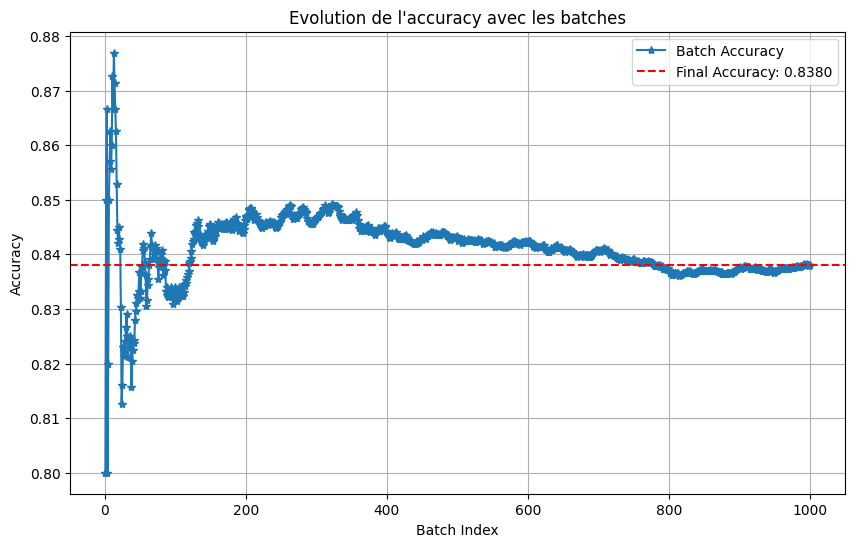

In [166]:
## Calcul de l'accuracy sur l'ensemble de test
GRU_CNN_accuracy, _ = calculate_accuracy(GRU_CNN_model, dataloader_test)

> Ce modèle affiche les meilleures performances en termes d'accuracy avec une `Accuracy = 83.8`, surpassant nettement les résultats obtenus par les modèles précédents.

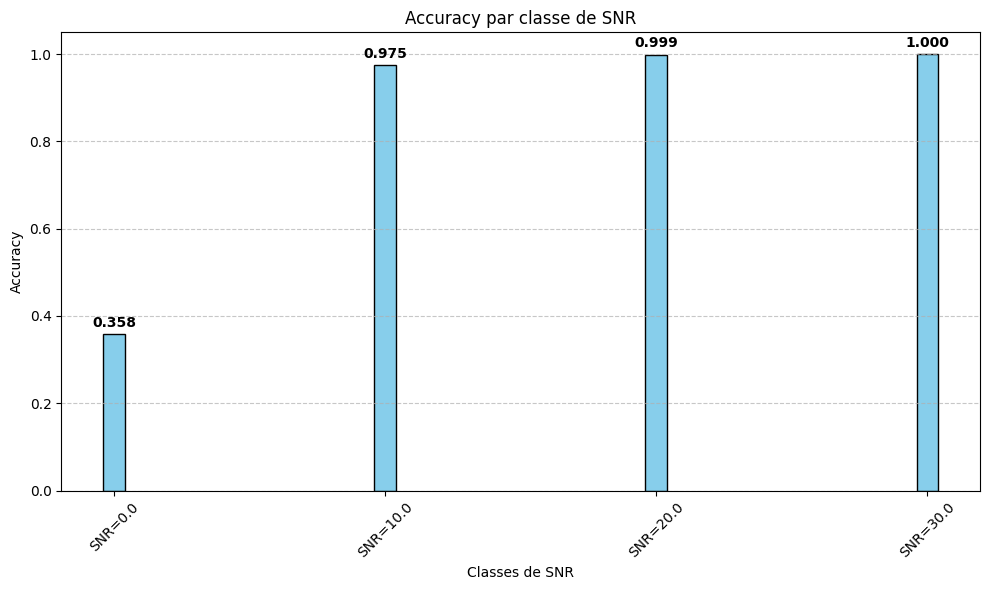

In [167]:
# Observation de l'accuracy par SNR
GRU_CNN_accuracy_per_snr = accuracy_by_SNR(path_test, GRU_CNN_model)

> - Les résultats pour les classes de `SNR = 10, 20 et 30` sont très bons. En effet, on observe une `accuracy` moyenne de `99%` pour ces classes, avec une accuracy de `100%` pour les `SNR = 20 et 30`.
> - En revanche, pour les signaux avec un `SNR = 0`, l'accuracy est inférieure à celle obtenue avec le modèle `CNN_GRU`. Cela entraîne un écart significatif entre cette classe de SNR et les autres. 

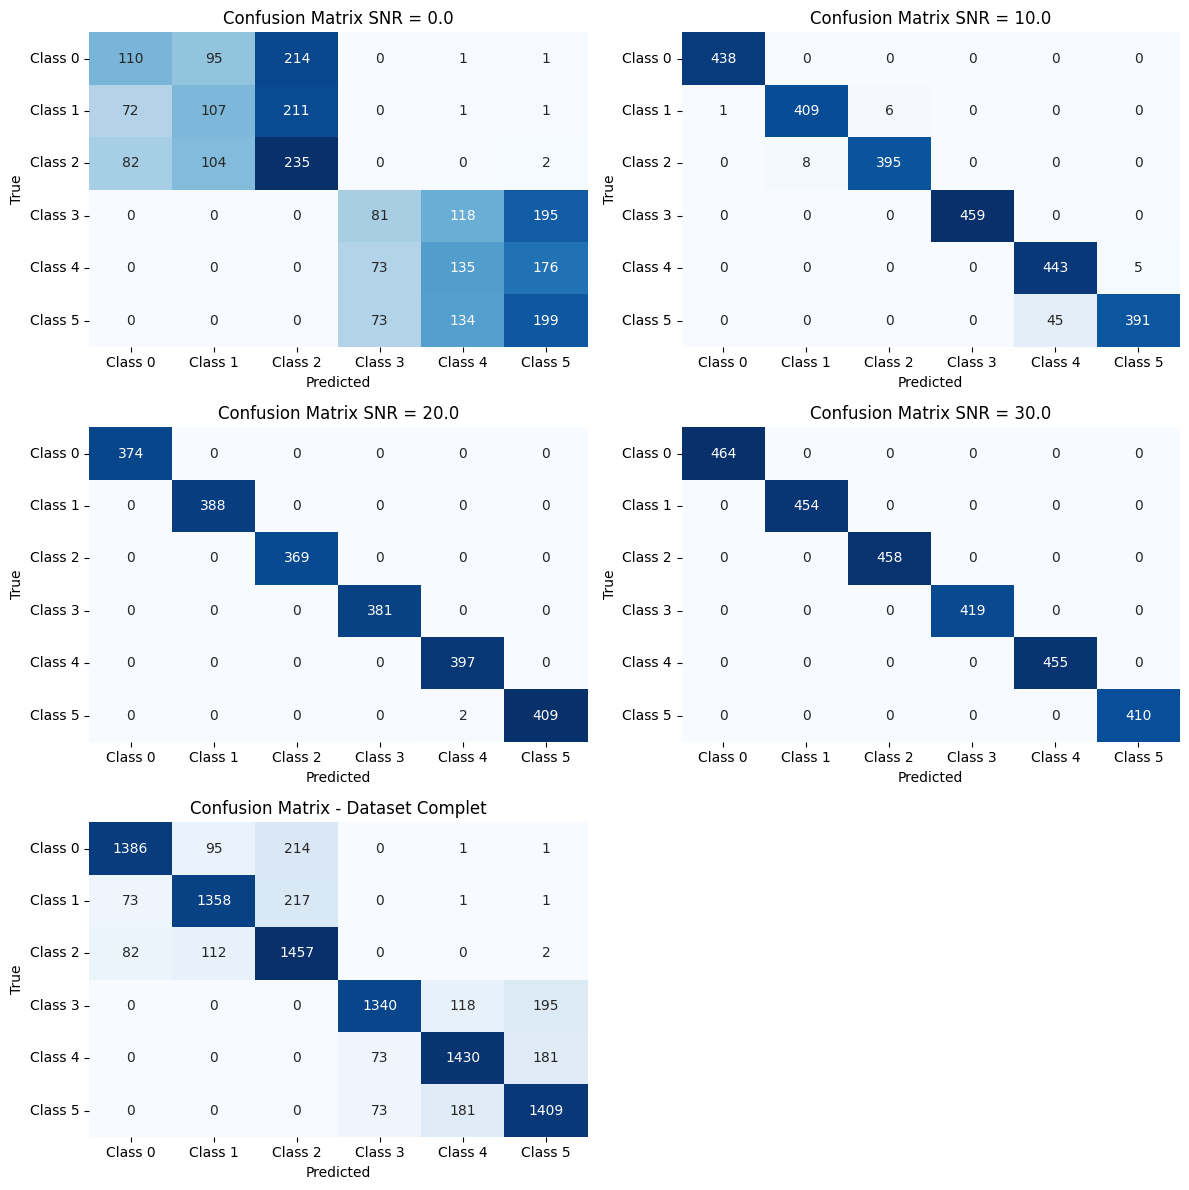

In [168]:
## Matrice de confusion par SNR
_, _ = confusion(path_test, GRU_CNN_model)

> - Pour la classe `SNR = 20` (resp. `SNR = 10`), on observe que seulement `2` (resp. `55`) signaux ont été mal classifiés. Toutefois, notre modèle a parfaitement classifié l'ensemble des signaux de la classe `SNR = 30`.
> - Le pattern observé pour les signaux avec un `SNR = 0` se manifeste également ici.

## Synthèse des résultats :
>Au cours de ce TP, nous avons pu tester trois architectures différentes pour résoudre un problème de classification multiclasses (6 classes) de signaux. Chaque signal se présentait sous la forme d'un tenseur pytorch à deux canaux (parties réelle et imaginaire) et de longueur 2048.
>Nos différentes archectures faisaient intervenir trois types de modèles "de base" vus en cours :
>- les convolutions 1D, pour pouvoir extraire des informations locales et pouvoir identifier des patterns locaux,
>- les GRU, qui sont une simplification des LSTM. L'objectif ici était d'exploiter la dimension temporelle (ordre d'apparition) des inputs pour pouvoir trouver des relations potentiellement à long terme entre les différentes parties de notre signal
>- les couches linéaires (MLP), l'idée ici était principalement de pouvoir avoir, en sortie, un tenseur de probabilités d'appartenance à chacune des classes.
In fine, notre modèle combinant à la fois des GRU dans un premier temps, puis des couches de convolution dans un second temps et, enfin, une couche dense est celui qui a obtenu la meilleure accuracy sur le dataser de test, avec un score de 83.80 %. Si ce modèle a des performances presque parfaites lorsqu'il s'agit de classer des signaux ayant un SNR supérieur ou égal à 10 dB, on pourrait néanmoins être un peu déçu par les performances de ce modèle lorsqu'il s'agit de classer correctement des signaux très bruités (SNR de 0 dB). En effet, pour une telle tâche, notre modèle, avec une accuracy de 35.8 % sur le SNR 0 dB, performe moins bien que le modèle baseline (accuracy de 36.9 % pour la même tâche) et encore moins bien que le modèle CNN_GRU (accuracy de 40.7 % pour la même tâche). Rappelons tout de même que le modèle GRU_CNN a plus de 4 millions de paramètres libres, c'est 500 fois plus que le modèle baseline et 30 fois plus que le modèle CNN_GRU. Ainsi, il apparaît que lorsque les signaux d'entrée sont très bruités, peu importe la taille de l'architecture, nos modèles n'arrivent pas à extraire des informations suffisamment discriminantes entre chaque classe. Ainsi, il serait peut-être intéressant d'ajouter une première "couche de débruitage", à la main (par des méthodes de filtrage par exemple, puisqu'on a vu notamment dans la partie "visualisation des données" que l'ouverture spectrale des signaux fortement bruités était plus importante que celle des signaux moins bruités).
>
>D'un point de vue hardware, nous avons fait tourner tous nos modèles sur un GPU Tesla T4, présent gratuitement (avec limite) sur Google Colab. Tous les modèles que nous avons pu entraîner (on a notamment pas mal joué sur le nombre de filtres des couches convolutives et la taille de leur kernel, mais cette partie là n'est pas présente, on a décidé de seulement garder le modèle le plus satisfaisant, i.e ayant la meilleure accuracy) ont tourné sans grands encombres en une quizaine de minutes, montre en main.